**LTA Mobility Sensing Project Part 3**
-  Statistical Feature-Based Approach for  Transport Mode Detection in Telemetry Data
- General Framework:

  1) Data Exploration

  2) Data Cleaning/Denoising

  3) Data Preparation/Scaling

  4) Feature Extraction/Selection

  5) Classifier Training/Tuning/Evaluation (Before and after upsampling/downsampling techniques)


**Import libraries**

**Read in excel file from Part 2**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df = pd.read_excel('acc_gyro_mag.xlsx', index_col = 0, header = 0)

In [0]:
df

waypoint_timeStart date_Start   JourneyID  ...     mag_X     mag_Y     mag_Z
0               00:17:48 2019-11-19  _or9hxk29h  ...  -45.3125   18.3125    2.3125
1               00:17:49 2019-11-19  _or9hxk29h  ...  -31.1250   27.7500   -2.1250
2               00:17:50 2019-11-19  _or9hxk29h  ...  -18.2500   24.3125   -6.2500
3               00:17:51 2019-11-19  _or9hxk29h  ...  -15.1250   17.8750   -4.3125
4               00:17:52 2019-11-19  _or9hxk29h  ...   -6.9375   20.5625   -7.6875
...                  ...        ...         ...  ...       ...       ...       ...
67458           07:54:03 2019-11-25  _hfvz81iog  ... -422.3750 -443.3750  419.6875
67459           07:54:04 2019-11-25  _hfvz81iog  ... -423.7500 -445.5000  418.3750
67460           07:54:05 2019-11-25  _hfvz81iog  ... -424.4375 -442.1250  418.8750
67461           07:54:06 2019-11-25  _hfvz81iog  ... -425.1250 -449.0000  420.0625
67462           07:54:07 2019-11-25  _hfvz81iog  ... -427.7500 -452.3750  421.1250

[67463 rows x 13 columns]

**Data Cleaning/Preparation**

Check for NAs

In [0]:
df.isna().sum()

waypoint_timeStart    0
date_Start            0
JourneyID             0
Mode                  0
acc_X                 0
acc_Y                 0
acc_Z                 0
gyro_X                0
gyro_Y                0
gyro_Z                0
mag_X                 0
mag_Y                 0
mag_Z                 0
dtype: int64

Check datatypes of columns and convert if necessary

In [0]:
df.dtypes

waypoint_timeStart            object
date_Start            datetime64[ns]
JourneyID                     object
Mode                          object
acc_X                        float64
acc_Y                        float64
acc_Z                        float64
gyro_X                       float64
gyro_Y                       float64
gyro_Z                       float64
mag_X                        float64
mag_Y                        float64
mag_Z                        float64
dtype: object

In [0]:
import datetime as dt

Convert waypoint_timeStart from object to timedelta64 data type

In [0]:
df['waypoint_timeStart'] = pd.to_timedelta(pd.to_datetime(df['waypoint_timeStart'],format='%H:%M:%S').dt.strftime('%H:%M:%S'))

In [0]:
df.dtypes

waypoint_timeStart    timedelta64[ns]
date_Start             datetime64[ns]
JourneyID                      object
Mode                           object
acc_X                         float64
acc_Y                         float64
acc_Z                         float64
gyro_X                        float64
gyro_Y                        float64
gyro_Z                        float64
mag_X                         float64
mag_Y                         float64
mag_Z                         float64
dtype: object

In [0]:
df.head()

waypoint_timeStart date_Start   JourneyID  ...    mag_X    mag_Y   mag_Z
0           00:17:48 2019-11-19  _or9hxk29h  ... -45.3125  18.3125  2.3125
1           00:17:49 2019-11-19  _or9hxk29h  ... -31.1250  27.7500 -2.1250
2           00:17:50 2019-11-19  _or9hxk29h  ... -18.2500  24.3125 -6.2500
3           00:17:51 2019-11-19  _or9hxk29h  ... -15.1250  17.8750 -4.3125
4           00:17:52 2019-11-19  _or9hxk29h  ...  -6.9375  20.5625 -7.6875

[5 rows x 13 columns]

**Data Exploration**

Check the labeled data distribution (Mode).

The outcome variable is **highly biased towards 'Idle' mode** which presents a class imbalance problem. We might need to consider oversampling and undersampling techniques before diving into the modeling stage.

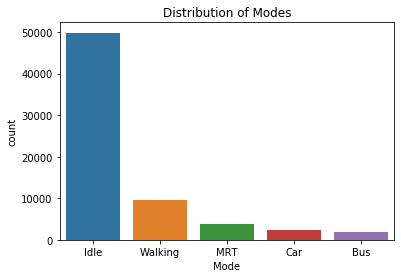

In [0]:
sns.countplot(x = 'Mode', data = df, order = df['Mode'].value_counts().index)
plt.title('Distribution of Modes');

Show class distribution in absolute and percentage figures

In [0]:
print('Count of each mode \n-------------------')
df.Mode.value_counts()

Count of each mode 
-------------------


Idle       49856
Walking     9563
MRT         3762
Car         2291
Bus         1991
Name: Mode, dtype: int64

In [0]:
print('Percentages of each mode (%) \n-----------------------------')
round(df.Mode.value_counts(normalize = True) * 100, 2)

Percentages of each mode (%) 
-----------------------------


Idle       73.90
Walking    14.18
MRT         5.58
Car         3.40
Bus         2.95
Name: Mode, dtype: float64

**Boxplots of all 3 sensors**

**Accelerometer**

- Walking, Bus, Car have wider range of accelerometer readings than Idle and MRT
- Idle and MRT have large number of outliers

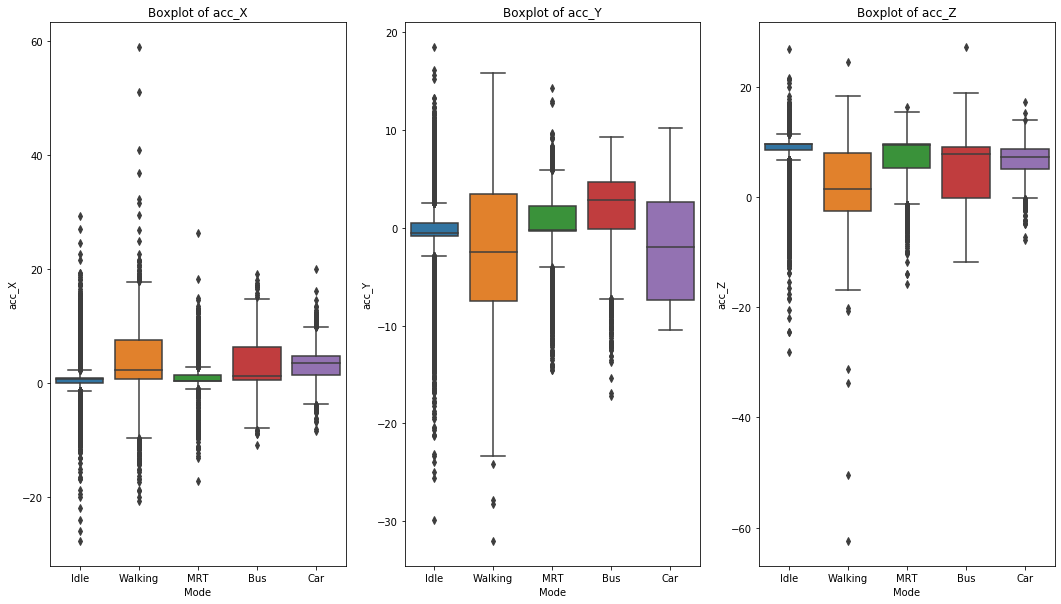

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Boxplot of acc_X')
axs[1].set_title('Boxplot of acc_Y')
axs[2].set_title('Boxplot of acc_Z')
sns.boxplot(x = 'Mode', y = 'acc_X', data = df, ax=axs[0])
sns.boxplot(x = 'Mode', y = 'acc_Y', data = df, ax=axs[1])
sns.boxplot(x = 'Mode', y = 'acc_Z', data = df, ax=axs[2]);

**Gyroscope**

- Lots of outliers (Might be hard for model to capture signal)
- Only Walking mode has visible Inter-quartile range (IQR), might be due to rhythmic movement of hands while walking. In other transport modes, more likely to hold phone in one position for an extended period of time
- IQR = Q3 - Q1

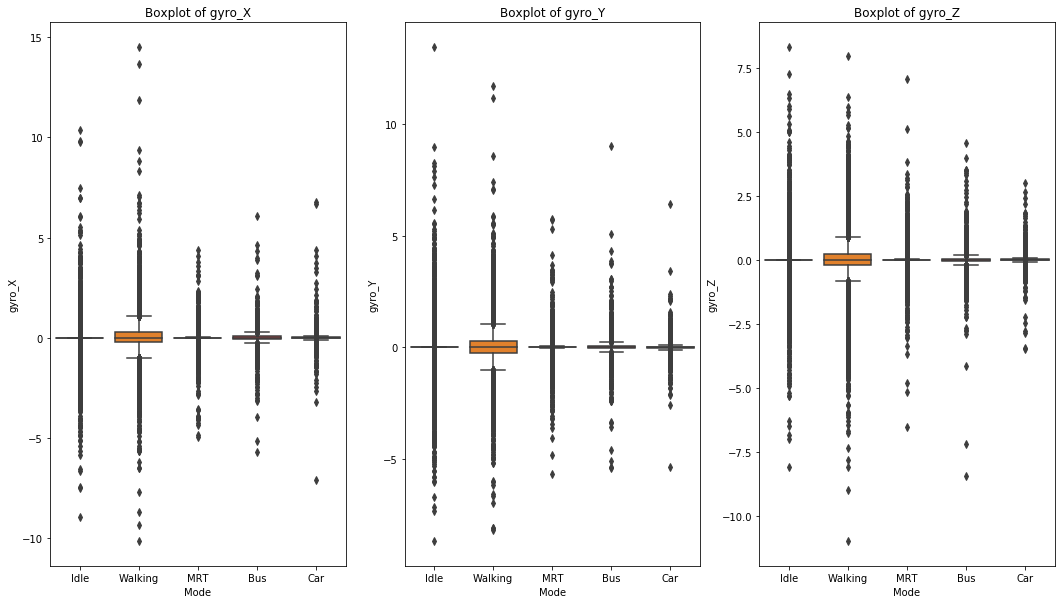

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Boxplot of gyro_X')
axs[1].set_title('Boxplot of gyro_Y')
axs[2].set_title('Boxplot of gyro_Z')
sns.boxplot(x = 'Mode', y = 'gyro_X', data = df, ax=axs[0])
sns.boxplot(x = 'Mode', y = 'gyro_Y', data = df, ax=axs[1])
sns.boxplot(x = 'Mode', y = 'gyro_Z', data = df, ax=axs[2]);

**Magnetometer**

- Car has significantly higher outliers compared to other 4 transport modes, followed by Idle then MRT

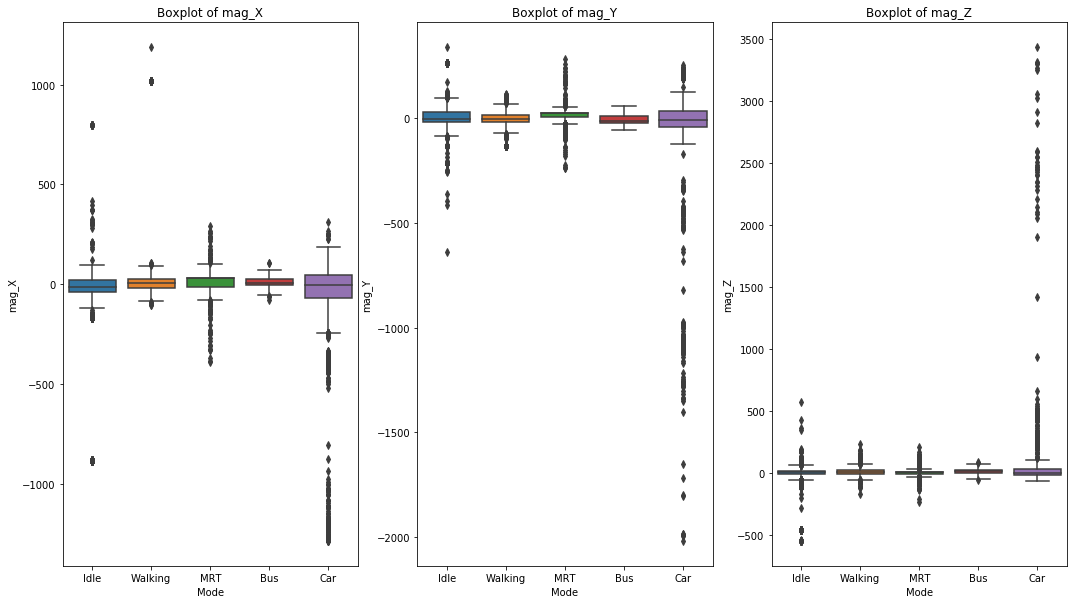

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Boxplot of mag_X')
axs[1].set_title('Boxplot of mag_Y')
axs[2].set_title('Boxplot of mag_Z')
sns.boxplot(x = 'Mode', y = 'mag_X', data = df, ax=axs[0])
sns.boxplot(x = 'Mode', y = 'mag_Y', data = df, ax=axs[1])
sns.boxplot(x = 'Mode', y = 'mag_Z', data = df, ax=axs[2]);

**Density Plots**

**Accelerometer Distribution Plot**

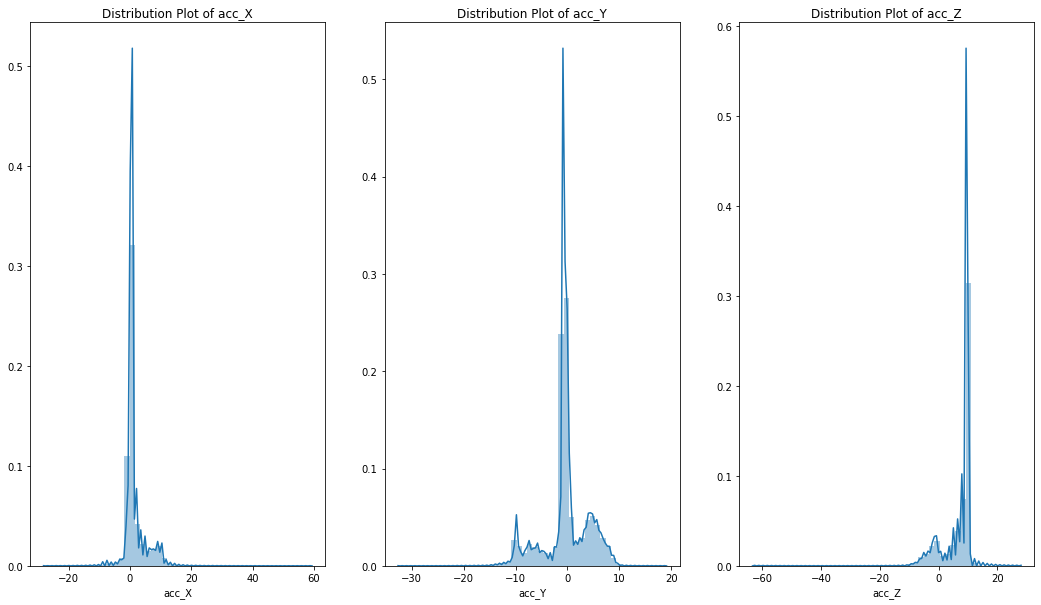

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Distribution Plot of acc_X')
axs[1].set_title('Distribution Plot of acc_Y')
axs[2].set_title('Distribution Plot of acc_Z')
sns.distplot(df.acc_X, ax=axs[0])
sns.distplot(df.acc_Y, ax=axs[1])
sns.distplot(df.acc_Z, ax=axs[2]);

**Gyroscope Distribution Plot**

- Most symmetrical out of the 3 types of sensors

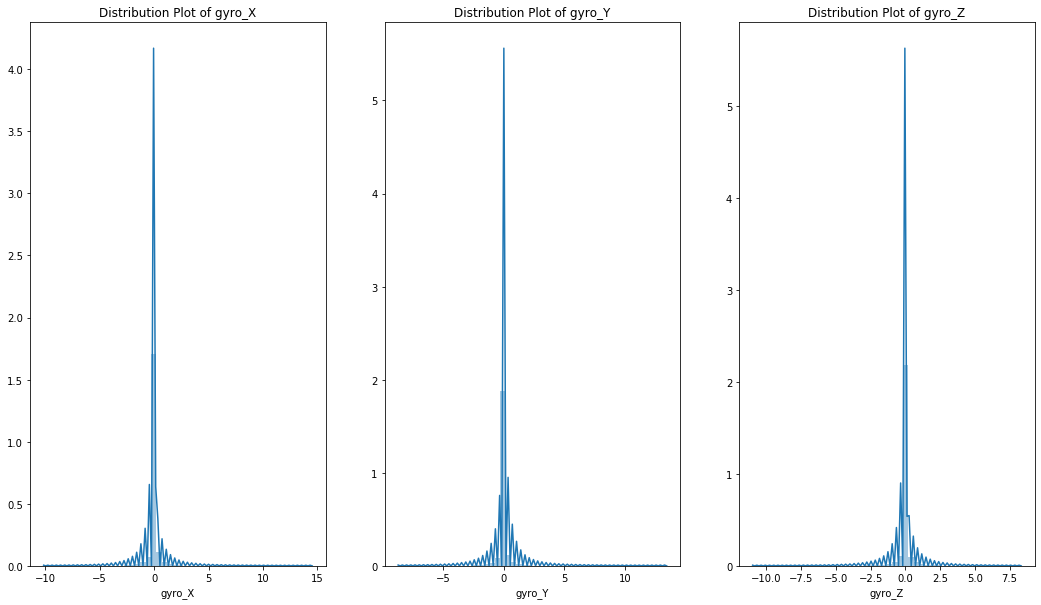

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Distribution Plot of gyro_X')
axs[1].set_title('Distribution Plot of gyro_Y')
axs[2].set_title('Distribution Plot of gyro_Z')
sns.distplot(df.gyro_X, ax=axs[0])
sns.distplot(df.gyro_Y, ax=axs[1])
sns.distplot(df.gyro_Z, ax=axs[2]);

**Magnetometer Distribution Plot**

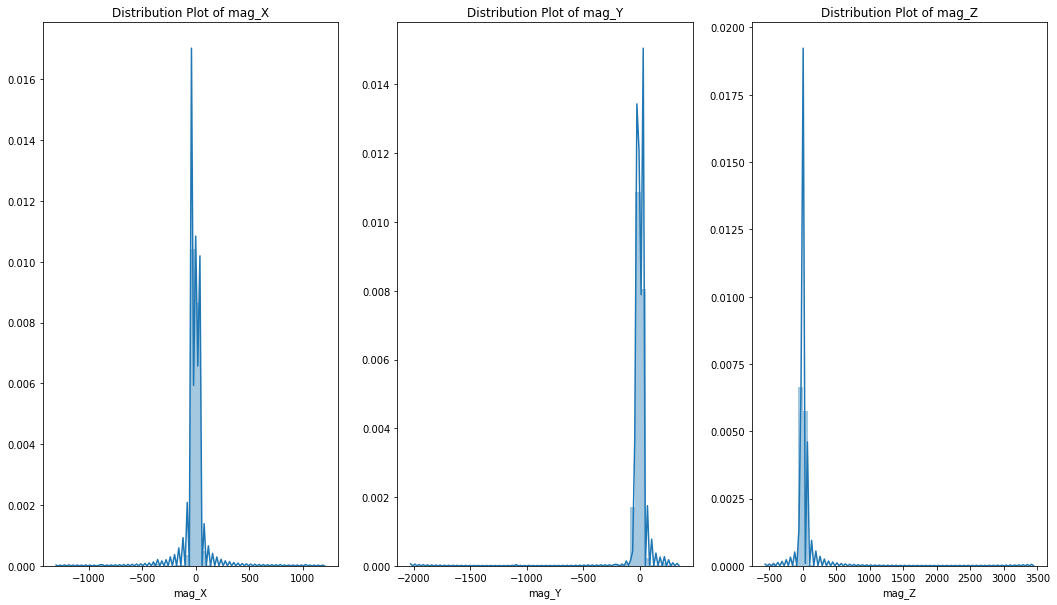

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Distribution Plot of mag_X')
axs[1].set_title('Distribution Plot of mag_Y')
axs[2].set_title('Distribution Plot of mag_Z')
sns.distplot(df.mag_X, ax=axs[0])
sns.distplot(df.mag_Y, ax=axs[1])
sns.distplot(df.mag_Z, ax=axs[2]);

**Visualize using a pair plot which allows us to see both distribution of single variables and relationships between two variables. Help to identify trends for follow-up analysis.**

- Diagonals are variable relationship with itself

- Mag_Y/Mag_Z appear to have a moderately strong linear relationship

- Mag_Y/Mag_X and Mag_Z/Mag_X also seem to have a linear relationship, albeit with more noise

- Other pairs are not that meaningful (either circular or t-shaped which signal little or no obvious relationship)

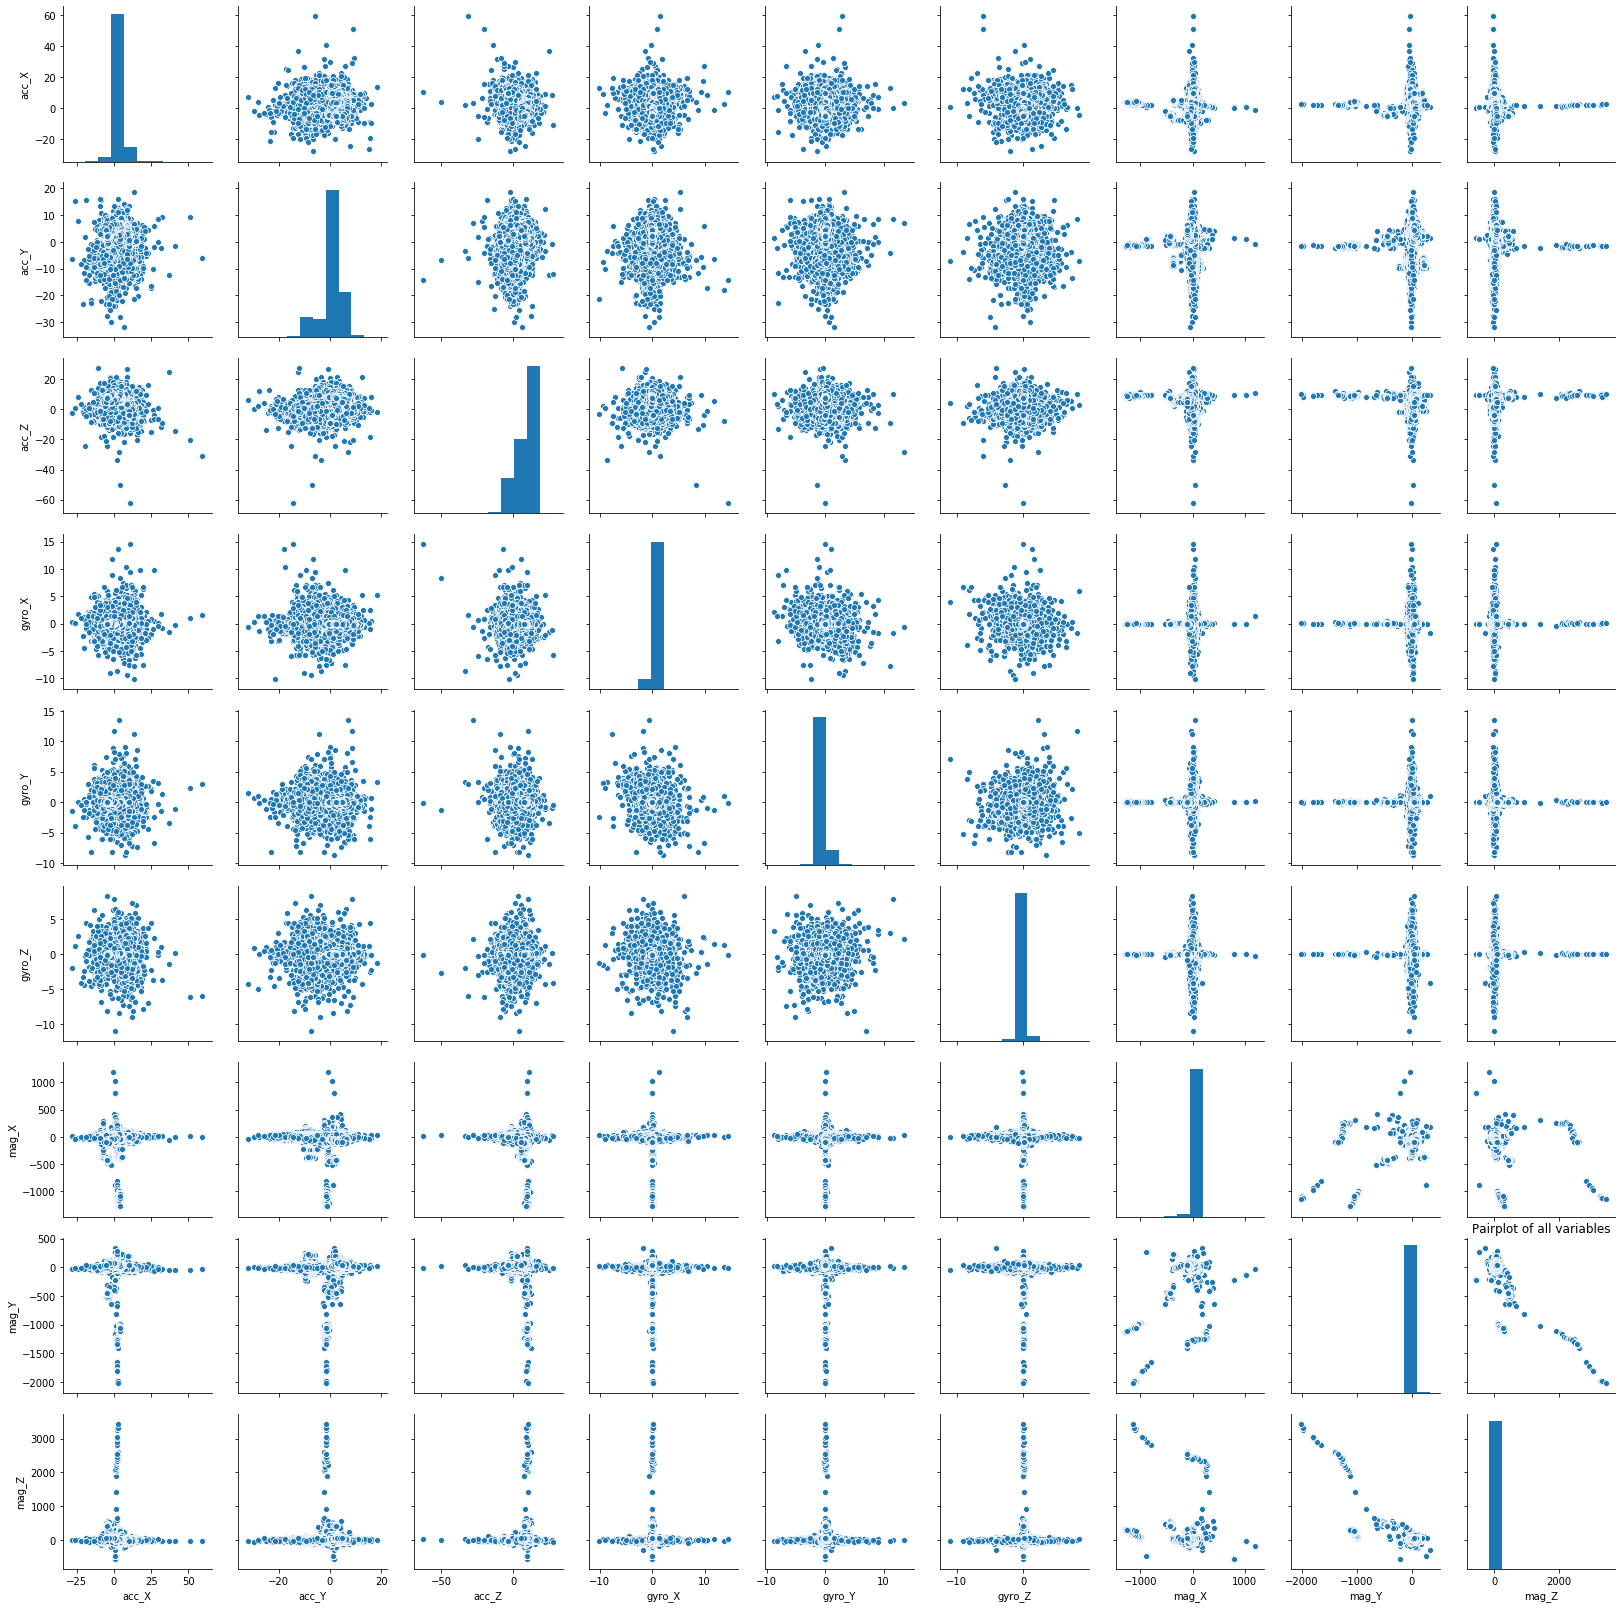

In [0]:
sns.pairplot(df)
plt.title('Pairplot of all variables');

**Aggregation Plots**

**Mean Plots**

- Idle and MRT have significantly lower mean Acc_X
- MRT has around -0.45 mean Acc_Y which is distinguishable from other modes 

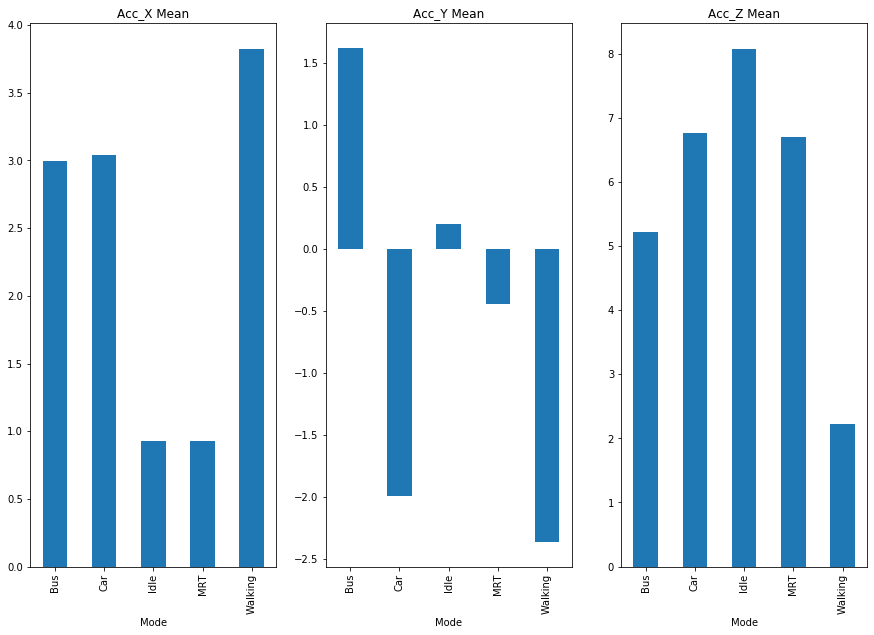

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(15,10)
df.groupby(["Mode"]).mean().unstack().acc_X.plot.bar(title = 'Acc_X Mean', ax=axs[0])
df.groupby(["Mode"]).mean().unstack().acc_Y.plot.bar(title = 'Acc_Y Mean', ax=axs[1])
df.groupby(["Mode"]).mean().unstack().acc_Z.plot.bar(title = 'Acc_Z Mean', ax=axs[2]);

- MRT has the lowest and in fact negative mean Gyro_X
- MRT has close to 0 mean Gyro_Y compared to Bus, Car, Idle
- MRT has the highest and significantly different Gyro_Z mean from other transport modes

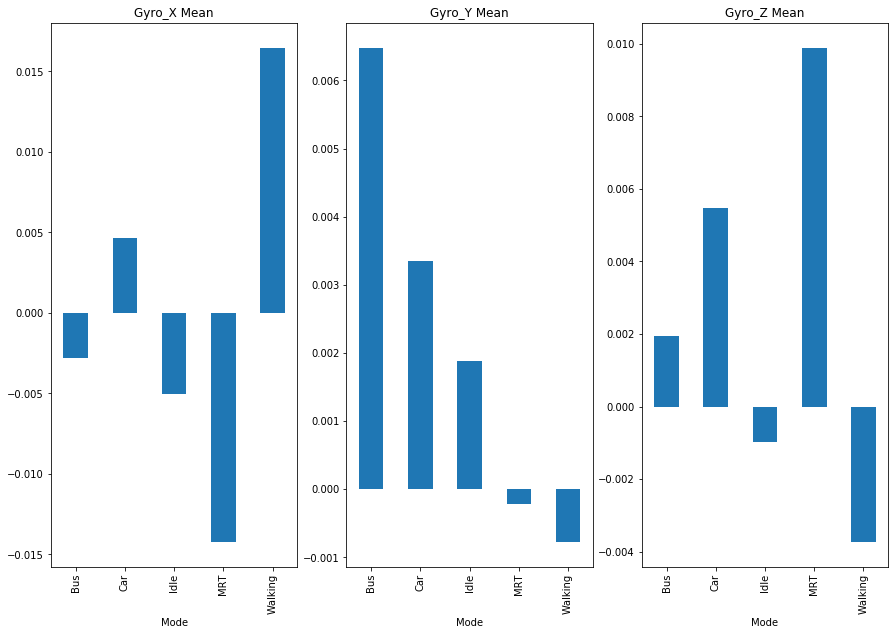

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(15,10)
df.groupby(["Mode"]).mean().unstack().gyro_X.plot.bar(title = 'Gyro_X Mean', ax=axs[0])
df.groupby(["Mode"]).mean().unstack().gyro_Y.plot.bar(title = 'Gyro_Y Mean', ax=axs[1])
df.groupby(["Mode"]).mean().unstack().gyro_Z.plot.bar(title = 'Gyro_Z Mean', ax=axs[2]);

- MRT has the highest mean Mag_X. Bus and Walking are close though which might impede the signal from the MRT.
- MRT is the only mode with a positive mean Mag_Y
- MRT has the lowest mean Mag_Z while Car has significantly high mean Mag_Z

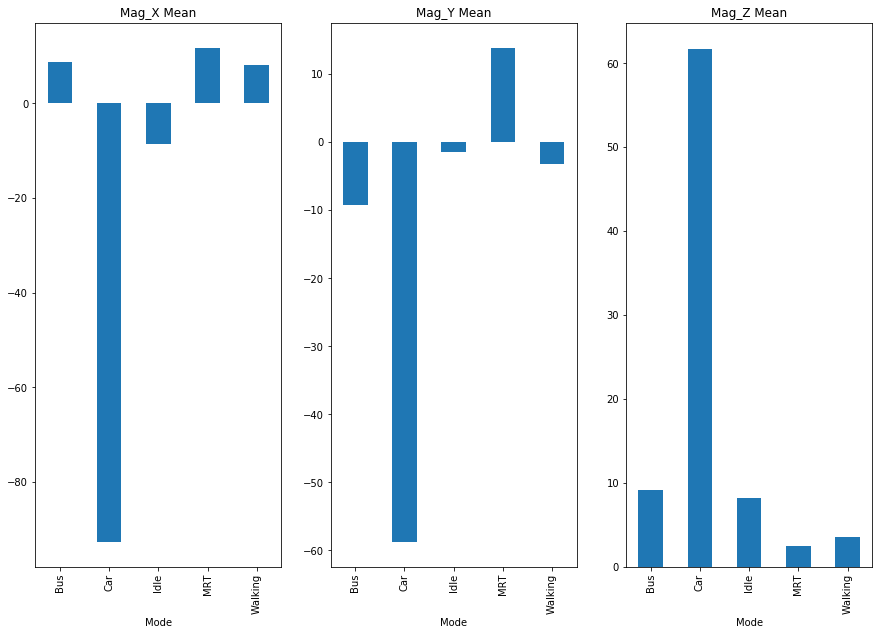

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(15,10)
df.groupby(["Mode"]).mean().unstack().mag_X.plot.bar(title = 'Mag_X Mean', ax=axs[0])
df.groupby(["Mode"]).mean().unstack().mag_Y.plot.bar(title = 'Mag_Y Mean', ax=axs[1])
df.groupby(["Mode"]).mean().unstack().mag_Z.plot.bar(title = 'Mag_Z Mean', ax=axs[2]);

**Median Plots**

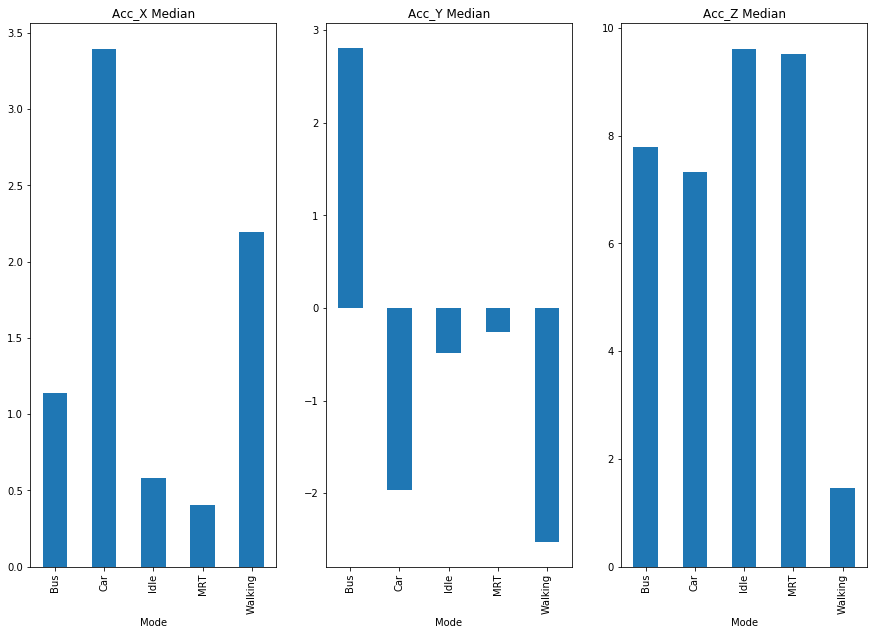

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(15,10)
df.groupby(["Mode"]).median().unstack().acc_X.plot.bar(title = 'Acc_X Median', ax=axs[0])
df.groupby(["Mode"]).median().unstack().acc_Y.plot.bar(title = 'Acc_Y Median', ax=axs[1])
df.groupby(["Mode"]).median().unstack().acc_Z.plot.bar(title = 'Acc_Z Median', ax=axs[2]);

Median gyro data might not be very useful here

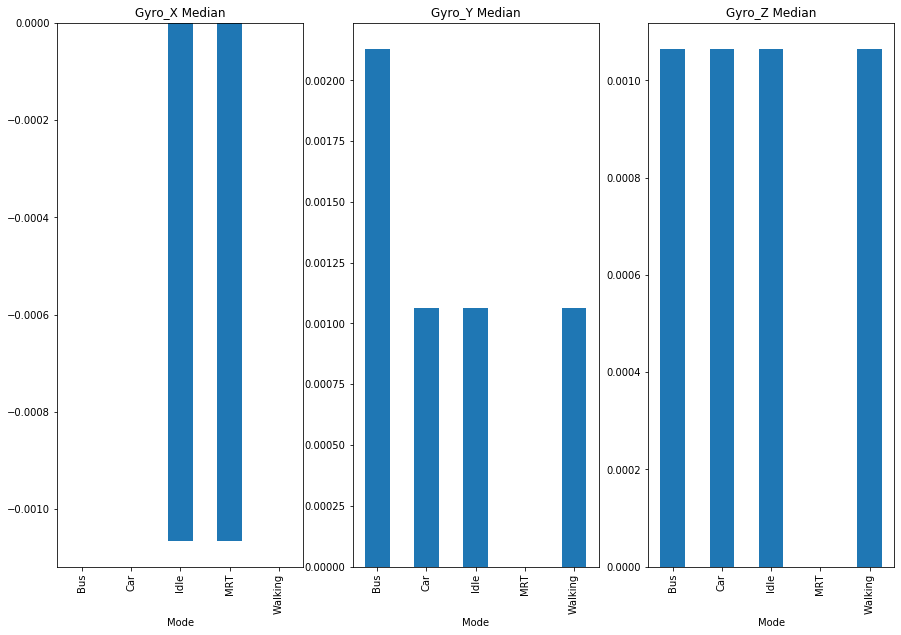

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(15,10)
df.groupby(["Mode"]).median().unstack().gyro_X.plot.bar(title = 'Gyro_X Median', ax=axs[0])
df.groupby(["Mode"]).median().unstack().gyro_Y.plot.bar(title = 'Gyro_Y Median', ax=axs[1])
df.groupby(["Mode"]).median().unstack().gyro_Z.plot.bar(title = 'Gyro_Z Median', ax=axs[2]);

Potential useful signal from median Mag_X and Mag_Y for MRT mode

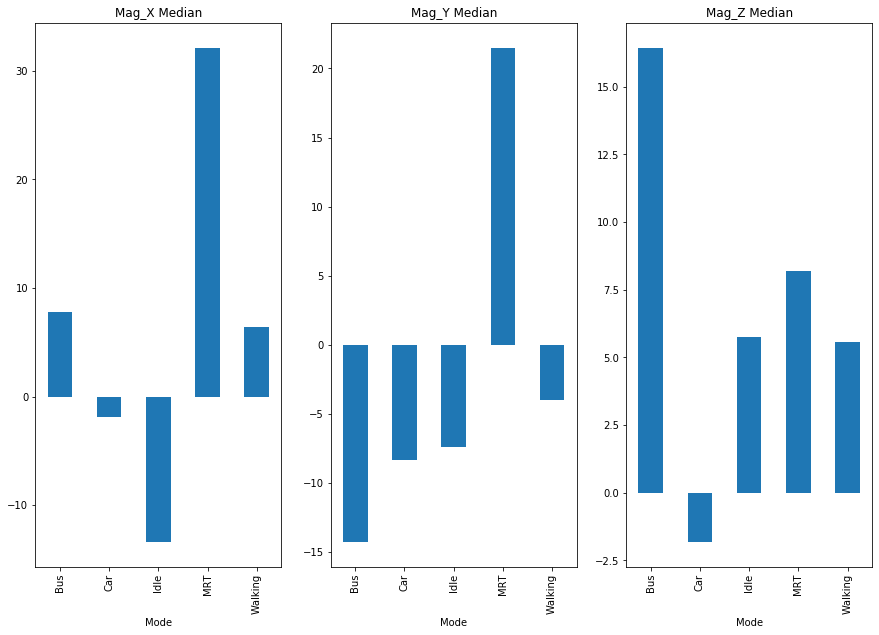

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(15,10)
df.groupby(["Mode"]).median().unstack().mag_X.plot.bar(title = 'Mag_X Median', ax=axs[0])
df.groupby(["Mode"]).median().unstack().mag_Y.plot.bar(title = 'Mag_Y Median', ax=axs[1])
df.groupby(["Mode"]).median().unstack().mag_Z.plot.bar(title = 'Mag_Z Median', ax=axs[2]);

**Time Series Plots**

**Accelerometer**

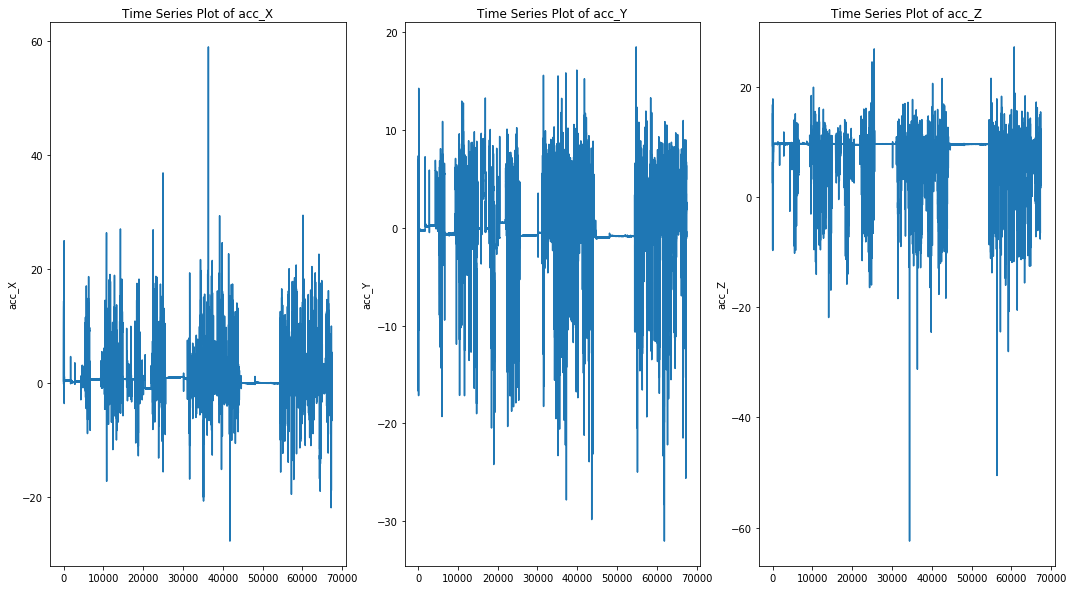

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Time Series Plot of acc_X')
axs[1].set_title('Time Series Plot of acc_Y')
axs[2].set_title('Time Series Plot of acc_Z')
sns.lineplot(x = df.index, y = 'acc_X', data = df, ax = axs[0])
sns.lineplot(x = df.index, y = 'acc_Y', data = df, ax = axs[1])
sns.lineplot(x = df.index, y = 'acc_Z', data = df, ax = axs[2]);

**Gyroscope**

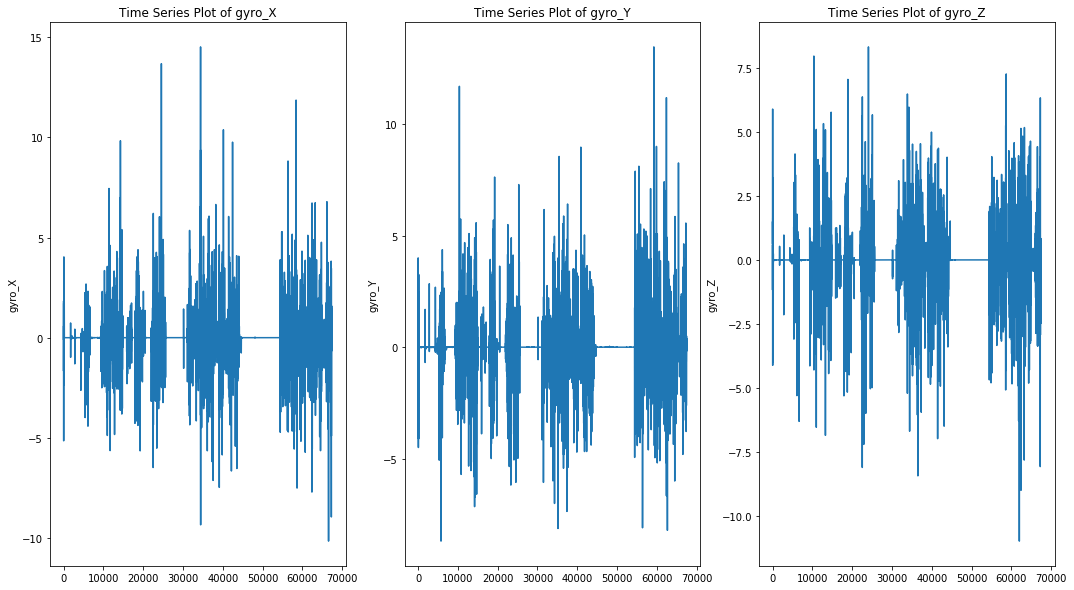

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Time Series Plot of gyro_X')
axs[1].set_title('Time Series Plot of gyro_Y')
axs[2].set_title('Time Series Plot of gyro_Z')
sns.lineplot(x = df.index, y = 'gyro_X', data = df, ax = axs[0])
sns.lineplot(x = df.index, y = 'gyro_Y', data = df, ax = axs[1])
sns.lineplot(x = df.index, y = 'gyro_Z', data = df, ax = axs[2]);

**Magnetometer**

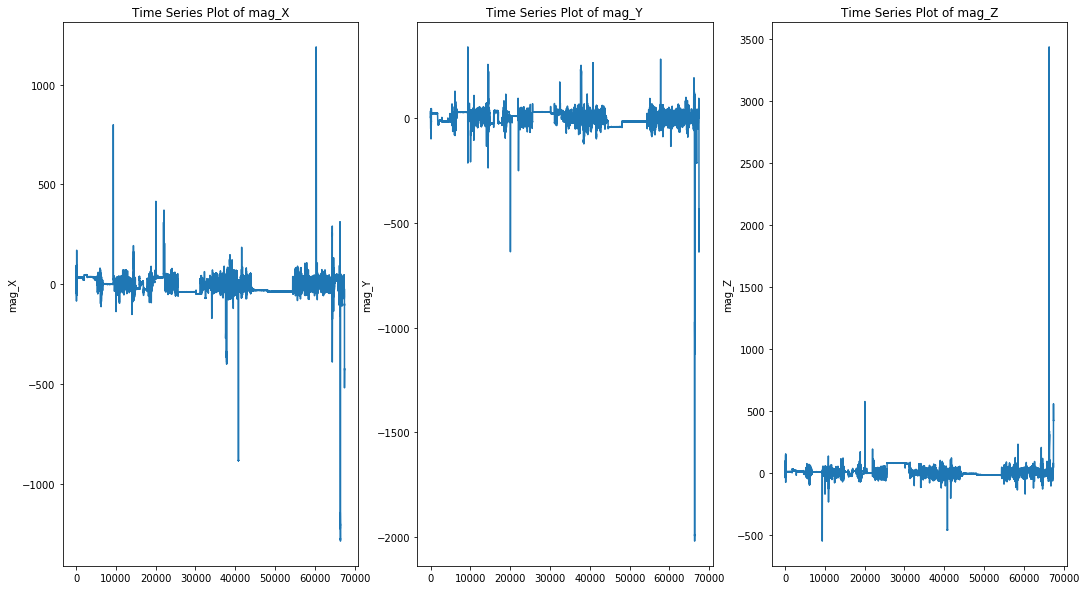

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Time Series Plot of mag_X')
axs[1].set_title('Time Series Plot of mag_Y')
axs[2].set_title('Time Series Plot of mag_Z')
sns.lineplot(x = df.index, y = 'mag_X', data = df, ax = axs[0])
sns.lineplot(x = df.index, y = 'mag_Y', data = df, ax = axs[1])
sns.lineplot(x = df.index, y = 'mag_Z', data = df, ax = axs[2]);

**Kalman Filter**
- From the above time series, the raw sensor data have lots of noise and is an important concern when building predictive models. Thus, we will be using kalman filter to denoise the sensor data.
- Kalman filtering is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe.

Note: 
- The Mode column is altered by making it into a binary classification. MRT mode remains as it is while all the other modes are renamed into Not_MRT.
- The kalman filter codes are written in another separate python script. We will be importing the filtered data directly here.

In [0]:
df1 = pd.read_excel('Kalman filtered data.xlsx', index_col = 0, header = 0)

In [0]:
df1

Mode     acc_X     acc_Y  ...       mag_X       mag_Y       mag_Z
0      Not_MRT -0.097415  4.086275  ...  -45.316035   18.310257    2.310214
1      Not_MRT  0.082932  2.136298  ...  -37.109343   23.769987   -0.276993
2      Not_MRT  1.592243  2.354539  ...  -27.593442   24.027156   -3.317166
3      Not_MRT  2.829395  3.076745  ...  -21.545934   21.011183   -3.820560
4      Not_MRT  3.703231  2.698886  ...  -14.528461   20.776580   -5.704259
...        ...       ...       ...  ...         ...         ...         ...
67458  Not_MRT -4.467465  2.170684  ... -427.317101 -440.051225  426.979627
67459  Not_MRT -4.318165  2.316991  ... -425.631856 -442.687647  422.826442
67460  Not_MRT -4.202396  2.478924  ... -425.086730 -442.435543  420.909141
67461  Not_MRT -4.386961  2.233518  ... -425.133888 -445.608057  420.483716
67462  Not_MRT -4.500364  2.291586  ... -426.419715 -448.877867  420.773248

[67463 rows x 10 columns]

Check the datatypes

In [0]:
df1.dtypes

Mode       object
acc_X     float64
acc_Y     float64
acc_Z     float64
gyro_X    float64
gyro_Y    float64
gyro_Z    float64
mag_X     float64
mag_Y     float64
mag_Z     float64
dtype: object

Change the column mode into a category type which is similar to factor in R. All the other sensor readings will remain as float64 data type.

In [0]:
df1['Mode'] = df1['Mode'].astype('category')

Double check the data type conversion has been performed successfully.

In [0]:
df1.dtypes

Mode      category
acc_X      float64
acc_Y      float64
acc_Z      float64
gyro_X     float64
gyro_Y     float64
gyro_Z     float64
mag_X      float64
mag_Y      float64
mag_Z      float64
dtype: object

Check for NAs.

No NAs found.

In [0]:
df1.isna().sum()

Mode      0
acc_X     0
acc_Y     0
acc_Z     0
gyro_X    0
gyro_Y    0
gyro_Z    0
mag_X     0
mag_Y     0
mag_Z     0
dtype: int64

Show class distribution in absolute and percentage figures

In [0]:
df1.Mode.value_counts()

Not_MRT    63701
MRT         3762
Name: Mode, dtype: int64

In [0]:
print('Percentages of each mode (%) \n-----------------------------')
round(df1.Mode.value_counts(normalize = True) * 100, 2)

Percentages of each mode (%) 
-----------------------------


Not_MRT    94.42
MRT         5.58
Name: Mode, dtype: float64

We will compare the time series plots before and after processing the sensor data using kalman filter.

**Accelerometer (Before and After)**

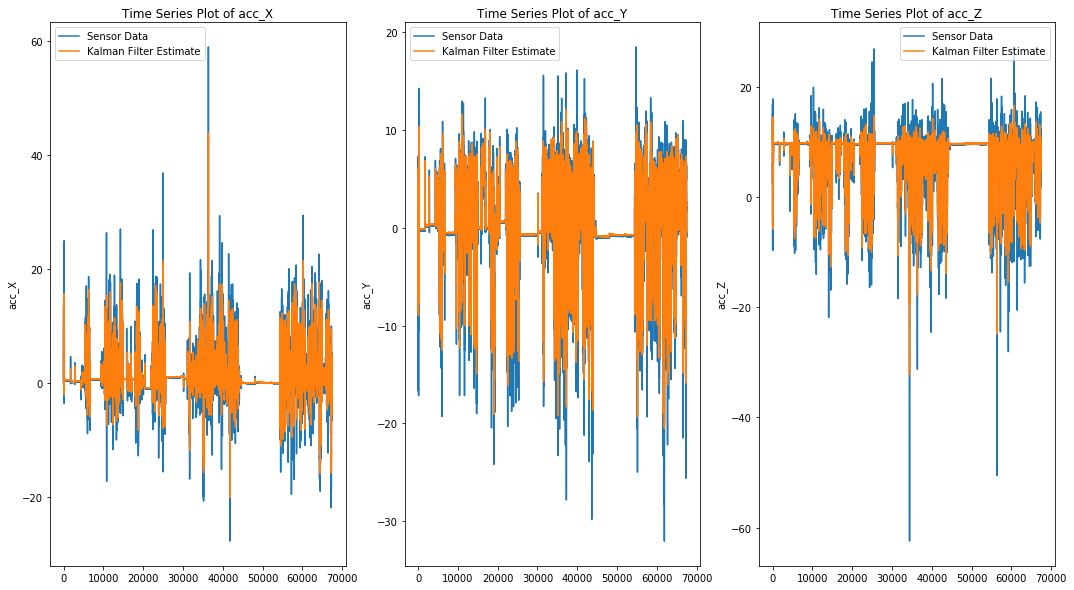

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Time Series Plot of acc_X')
axs[1].set_title('Time Series Plot of acc_Y')
axs[2].set_title('Time Series Plot of acc_Z')
sns.lineplot(x = df.index, y = 'acc_X', data = df, ax = axs[0])
sns.lineplot(x = df.index, y = 'acc_Y', data = df, ax = axs[1])
sns.lineplot(x = df.index, y = 'acc_Z', data = df, ax = axs[2])
sns.lineplot(x = df.index, y = 'acc_X', data = df1, ax = axs[0])
sns.lineplot(x = df.index, y = 'acc_Y', data = df1, ax = axs[1])
sns.lineplot(x = df.index, y = 'acc_Z', data = df1, ax = axs[2])
for i in range(3):
  axs[i].legend(labels=['Sensor Data', 'Kalman Filter Estimate']);

**Gyroscope (Before and After)**

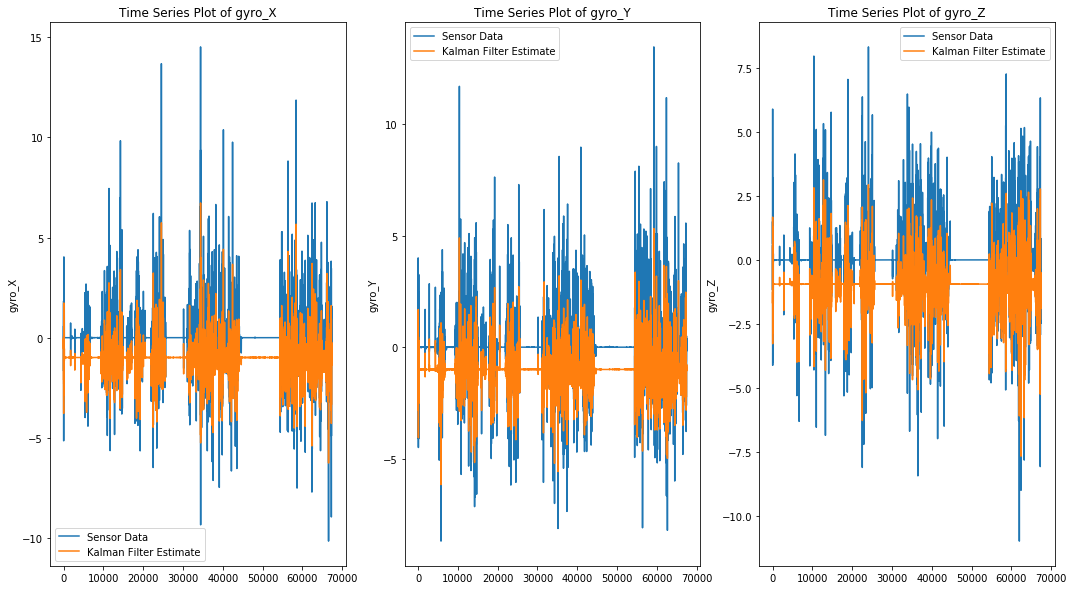

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Time Series Plot of gyro_X')
axs[1].set_title('Time Series Plot of gyro_Y')
axs[2].set_title('Time Series Plot of gyro_Z')
sns.lineplot(x = df.index, y = 'gyro_X', data = df, ax = axs[0])
sns.lineplot(x = df.index, y = 'gyro_Y', data = df, ax = axs[1])
sns.lineplot(x = df.index, y = 'gyro_Z', data = df, ax = axs[2])
sns.lineplot(x = df.index, y = 'gyro_X', data = df1, ax = axs[0])
sns.lineplot(x = df.index, y = 'gyro_Y', data = df1, ax = axs[1])
sns.lineplot(x = df.index, y = 'gyro_Z', data = df1, ax = axs[2])
for i in range(3):
  axs[i].legend(labels=['Sensor Data', 'Kalman Filter Estimate']);

**Magnetometer (Before and After)**

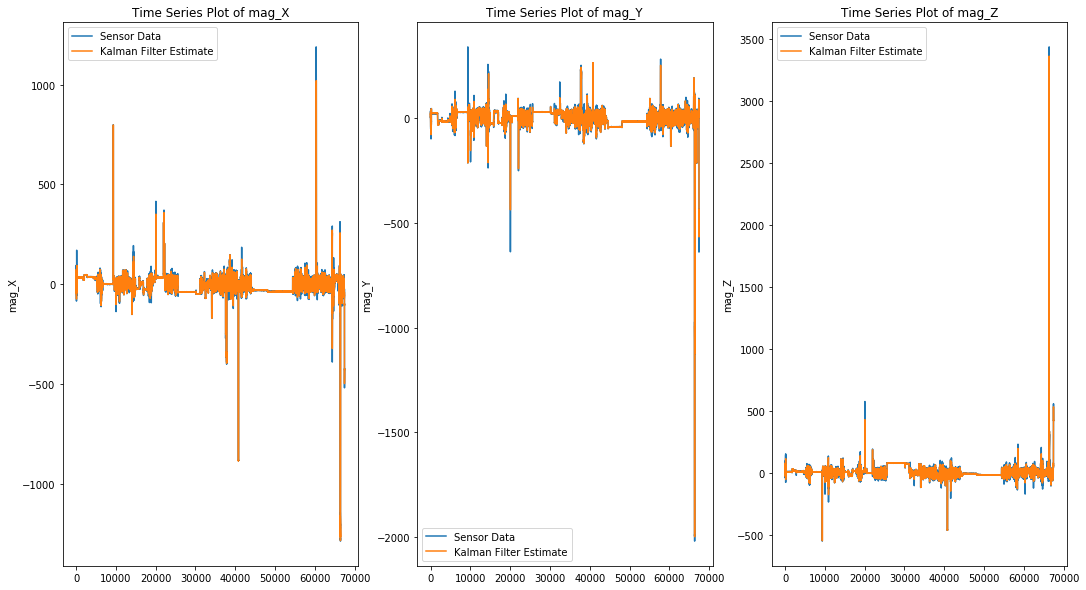

In [0]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(18,10)
axs[0].set_title('Time Series Plot of mag_X')
axs[1].set_title('Time Series Plot of mag_Y')
axs[2].set_title('Time Series Plot of mag_Z')
sns.lineplot(x = df.index, y = 'mag_X', data = df, ax = axs[0])
sns.lineplot(x = df.index, y = 'mag_Y', data = df, ax = axs[1])
sns.lineplot(x = df.index, y = 'mag_Z', data = df, ax = axs[2])
sns.lineplot(x = df.index, y = 'mag_X', data = df1, ax = axs[0])
sns.lineplot(x = df.index, y = 'mag_Y', data = df1, ax = axs[1])
sns.lineplot(x = df.index, y = 'mag_Z', data = df1, ax = axs[2])
for i in range(3):
  axs[i].legend(labels=['Sensor Data', 'Kalman Filter Estimate']);

**Scatterplots of all kalman filtered X features**
- Ignore all the first plot as it represents the correlation of the feature against itself
- Most features are not able to distinguish between MRT and Not_MRT
- Mag_X and Acc_X has an interesting separation though
- Feature extraction will therefore be required to obtain better separation between MRT and Not_MRT

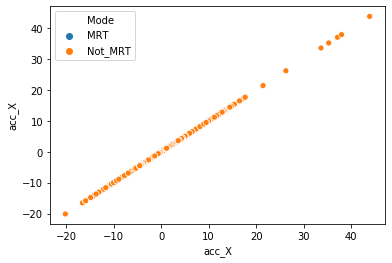

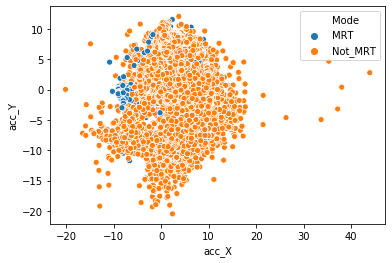

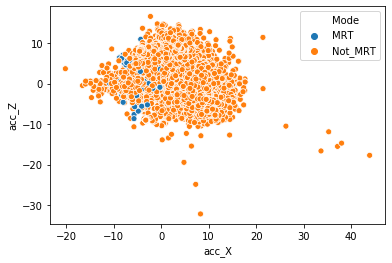

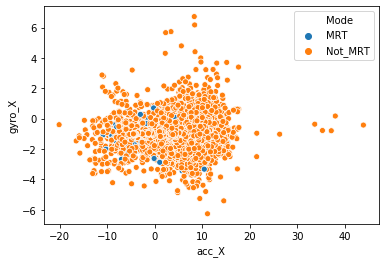

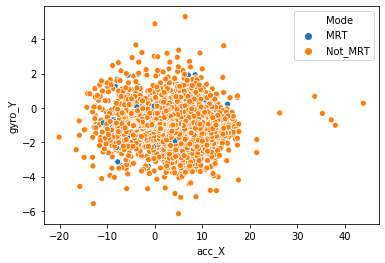

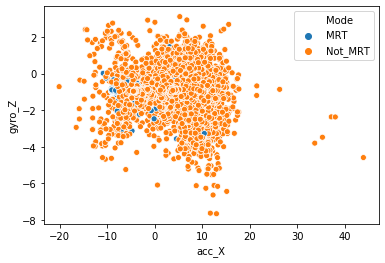

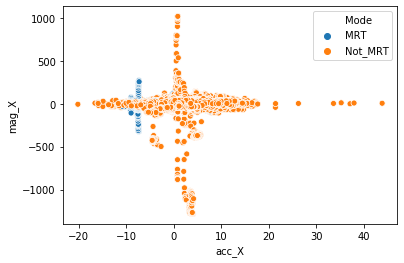

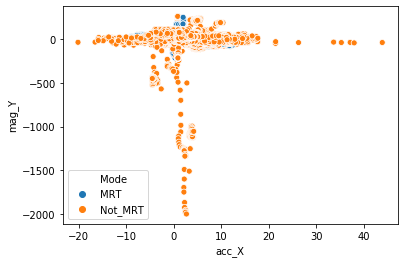

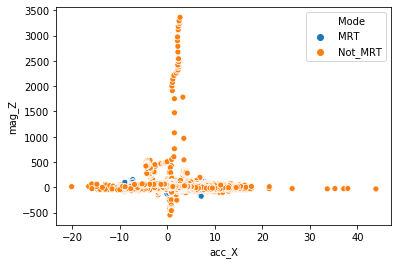

In [0]:
for i, col in enumerate(df1.columns[1:]):
    plt.figure(i)
    sns.scatterplot(df1.iloc[:, 1], df1.iloc[:, i + 1], hue = df1['Mode'])

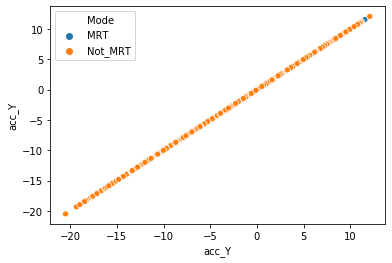

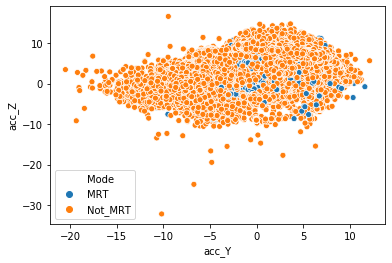

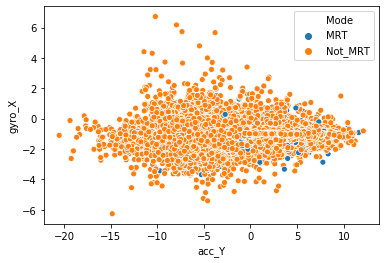

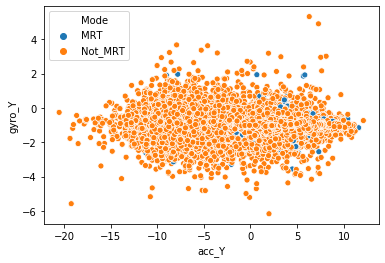

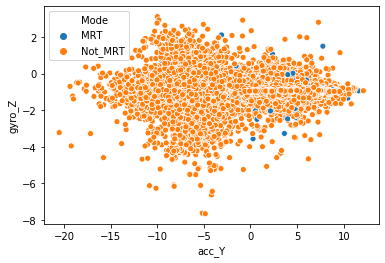

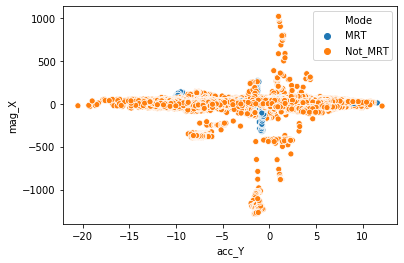

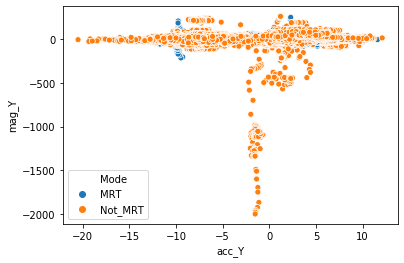

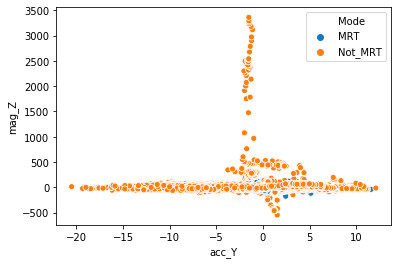

In [0]:
for i, col in enumerate(df1.columns[2:]):
    plt.figure(i)
    sns.scatterplot(df1.iloc[:, 2], df1.iloc[:, i + 2], hue = df1['Mode'])

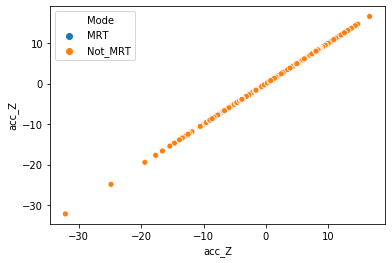

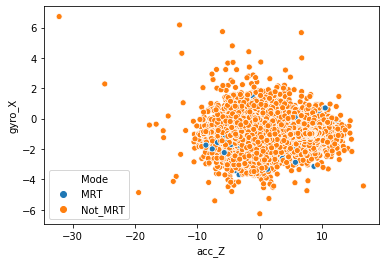

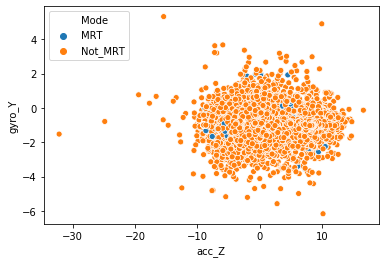

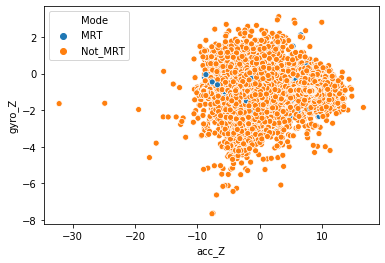

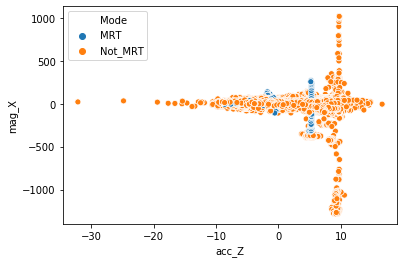

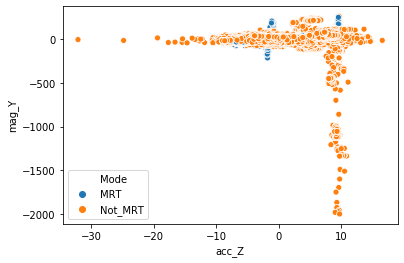

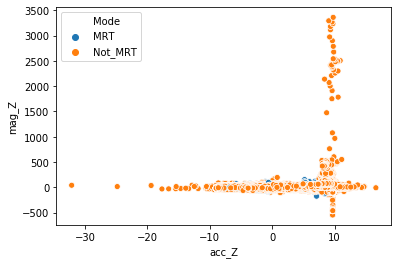

In [0]:
for i, col in enumerate(df1.columns[3:]):
    plt.figure(i)
    sns.scatterplot(df1.iloc[:, 3], df1.iloc[:, i + 3], hue = df1['Mode'])

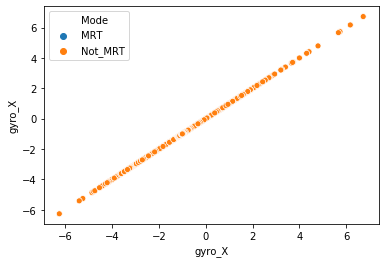

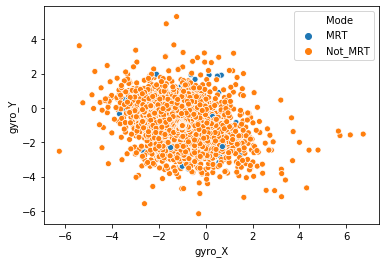

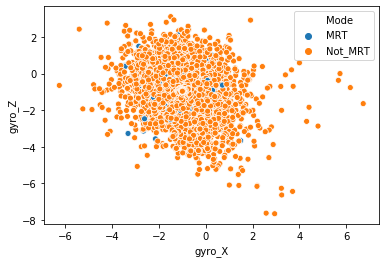

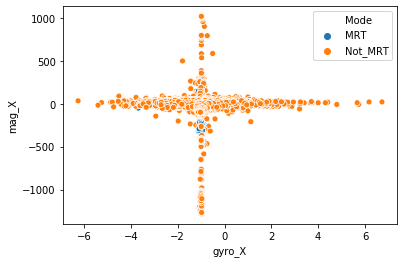

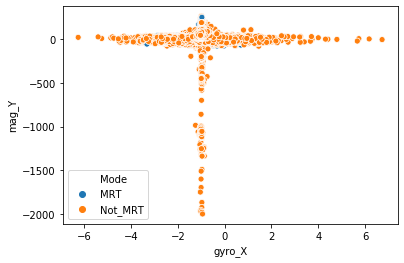

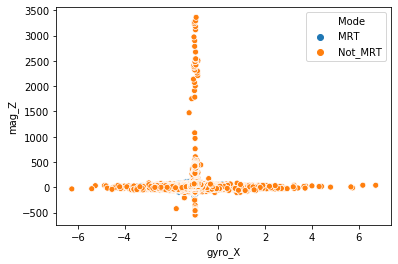

In [0]:
for i, col in enumerate(df1.columns[4:]):
    plt.figure(i)
    sns.scatterplot(df1.iloc[:, 4], df1.iloc[:, i + 4], hue = df1['Mode'])

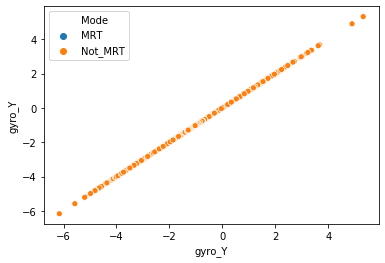

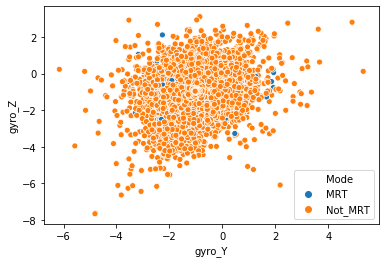

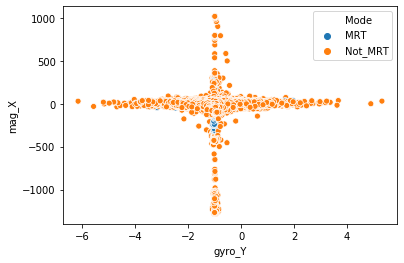

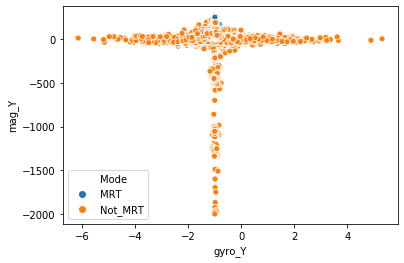

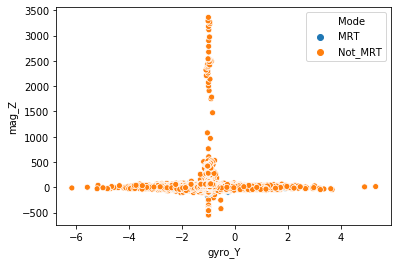

In [0]:
for i, col in enumerate(df1.columns[5:]):
    plt.figure(i)
    sns.scatterplot(df1.iloc[:, 5], df1.iloc[:, i + 5], hue = df1['Mode'])

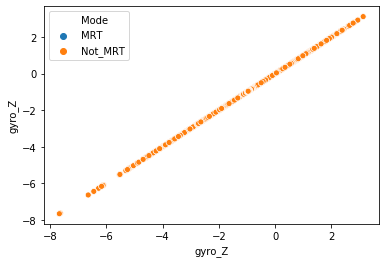

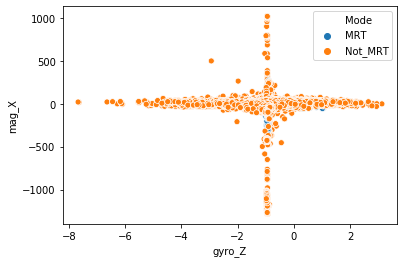

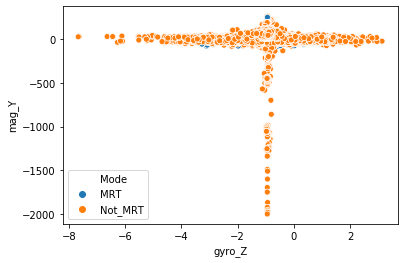

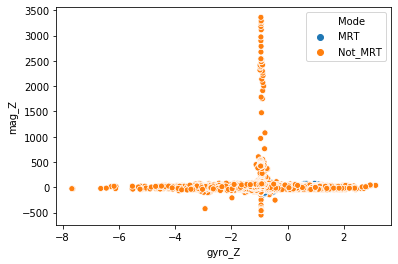

In [0]:
for i, col in enumerate(df1.columns[6:]):
    plt.figure(i)
    sns.scatterplot(df1.iloc[:, 6], df1.iloc[:, i + 6], hue = df1['Mode'])

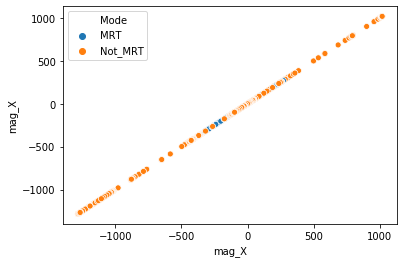

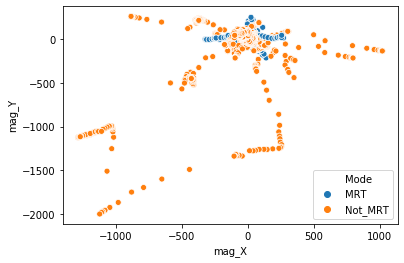

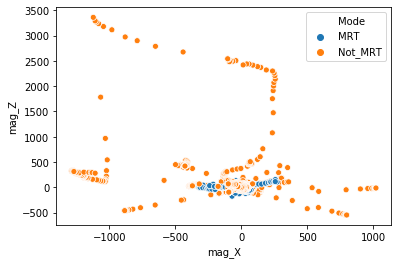

In [0]:
for i, col in enumerate(df1.columns[7:]):
    plt.figure(i)
    sns.scatterplot(df1.iloc[:, 7], df1.iloc[:, i + 7], hue = df1['Mode'])

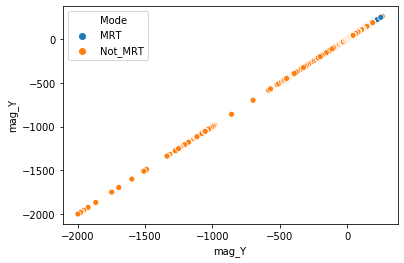

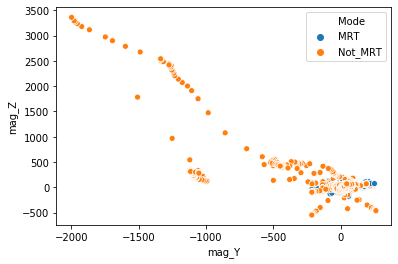

In [0]:
for i, col in enumerate(df1.columns[8:]):
    plt.figure(i)
    sns.scatterplot(df1.iloc[:, 8], df1.iloc[:, i + 8], hue = df1['Mode'])

**Feature Extraction**

Main idea: Transformation of patterns into features that are considered as a compressed representation

- For each time series variable, key statistical features will be extracted to measure different properties of that variable. 
- Main groups of the calculated statistical measures (Non-exhaustive):
  
  1) Measures of Central Tendency (Mean, Median)

  2) Measures of Variability (Variance, Standard Deviation, IQR, Range)

  3) Measures of Shape (Skewness, Kurtosis)

  4) Measures of Position (Percentiles)

  5) Measures of Impurity (Entropy)

- Need to determine a moving window size to calculate the above features (An initial size of window 10 is chosen)
-------------------------------------------------------------------

**Magnitude Vector**
- Before extracting the features, a magnitude vector is calculated from each sensor to obtain 3 extra data sources.
- The formula for the magnitude of a vector can be generalized to arbitrary dimensions. For example, if a = (a1,a2,a3,a4) is a four-dimensional vector, the formula for its magnitude is ∥a∥ = √a21+a22+a23+a24.

In [0]:
df1['total_acc'] = np.sqrt(np.square(df1.iloc[:, 1:4]).sum(axis=1))
df1['total_gyro'] = np.sqrt(np.square(df1.iloc[:, 4:7]).sum(axis=1))
df1['total_mag'] = np.sqrt(np.square(df1.iloc[:, 7:10]).sum(axis=1))

In [0]:
df1.head()

Mode     acc_X     acc_Y  ...  total_acc  total_gyro  total_mag
0  Not_MRT -0.097415  4.086275  ...  10.187329    0.601050  48.930007
1  Not_MRT  0.082932  2.136298  ...  10.006204    0.591398  44.070311
2  Not_MRT  1.592243  2.354539  ...  12.022321    0.926897  36.738343
3  Not_MRT  2.829395  3.076745  ...  12.953133    0.776990  30.336344
4  Not_MRT  3.703231  2.698886  ...  15.205328    1.010734  25.986170

[5 rows x 13 columns]

Rearrange the columns according to sensor type

In [0]:
columnsTitles = ['Mode',
                 'acc_X', 'acc_Y', 'acc_Z', 'total_acc', 
                 'gyro_X', 'gyro_Y', 'gyro_Z', 'total_gyro',
                 'mag_X', 'mag_Y', 'mag_Z', 'total_mag']
df1 = df1.reindex(columns = columnsTitles)

In [0]:
df1.head()

Mode     acc_X     acc_Y  ...      mag_Y     mag_Z  total_mag
0  Not_MRT -0.097415  4.086275  ...  18.310257  2.310214  48.930007
1  Not_MRT  0.082932  2.136298  ...  23.769987 -0.276993  44.070311
2  Not_MRT  1.592243  2.354539  ...  24.027156 -3.317166  36.738343
3  Not_MRT  2.829395  3.076745  ...  21.011183 -3.820560  30.336344
4  Not_MRT  3.703231  2.698886  ...  20.776580 -5.704259  25.986170

[5 rows x 13 columns]

In [0]:
df1.isna().sum()

Mode          0
acc_X         0
acc_Y         0
acc_Z         0
total_acc     0
gyro_X        0
gyro_Y        0
gyro_Z        0
total_gyro    0
mag_X         0
mag_Y         0
mag_Z         0
total_mag     0
dtype: int64

In [0]:
df1.shape

(67463, 13)

**Train-Test Split**
- Perform a 70/30 train test split with stratification to ensure balanced Y distribution in both train and test sets.
- Set seed for reproducible results.

To minimize data leakage when developing predictive models:
- Perform data preparation within training set.
- Hold back a test set for final sanity check of the developed models.

In [0]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [0]:
np.random.seed(5)
X = df1.iloc[:, 1:]
Y = df1.iloc[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 0)

As the index are messed up after the train test split with stratification, we will reorder back the index which is equivalent to ordering back the timestamp. This allows our calculated rolling features to be much more meaningful than random mixing of rows.

In [0]:
X_train.sort_index(inplace = True)
X_test.sort_index(inplace = True)
Y_train.sort_index(inplace = True)
Y_test.sort_index(inplace = True);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
X_train.head()

acc_X     acc_Y      acc_Z  ...      mag_Y      mag_Z  total_mag
0 -0.097415  4.086275   9.331374  ...  18.310257   2.310214  48.930007
1  0.082932  2.136298   9.775145  ...  23.769987  -0.276993  44.070311
3  2.829395  3.076745  12.260172  ...  21.011183  -3.820560  30.336344
4  3.703231  2.698886  14.498417  ...  20.776580  -5.704259  25.986170
6  3.491388  2.924738  10.083226  ...  14.180117 -11.070007  22.502088

[5 rows x 12 columns]

In [0]:
X_test.head()

acc_X     acc_Y      acc_Z  ...      mag_Y      mag_Z  total_mag
2   1.592243  2.354539  11.681486  ...  24.027156  -3.317166  36.738343
5   3.210786  2.996559  12.419961  ...  18.430753  -9.652968  23.834224
11  3.776771  3.113791   7.007051  ...   6.386938 -19.911611  31.805960
13  5.096154  0.220397  10.995373  ...  14.381845  -7.361833  22.766365
19  4.282188  2.731944  11.442851  ...  17.081569  24.904773  33.504963

[5 rows x 12 columns]

In [0]:
Y_train.head()

0    Not_MRT
1    Not_MRT
3    Not_MRT
4    Not_MRT
6    Not_MRT
Name: Mode, dtype: category
Categories (2, object): [MRT, Not_MRT]

In [0]:
Y_test.head()

2     Not_MRT
5     Not_MRT
11    Not_MRT
13    Not_MRT
19    Not_MRT
Name: Mode, dtype: category
Categories (2, object): [MRT, Not_MRT]

Check equal distribution of Y 

In [0]:
unique1, counts1 = np.unique(Y_train, return_counts = True)
unique2, counts2 = np.unique(Y_test, return_counts = True)
print(np.asarray((unique1, counts1)).T)
print(np.asarray((unique2, counts2)).T)

[['MRT' 2633]
 ['Not_MRT' 44591]]
[['MRT' 1129]
 ['Not_MRT' 19110]]


In [0]:
print('% of MRT: {:.2f}%'.format(counts1[0] / counts1[1] * 100))
print('% of MRT: {:.2f}%'.format(counts2[0] / counts2[1] * 100))

% of MRT: 5.90%
% of MRT: 5.91%


Check the train and test sets

In [0]:
set_name = ['X_train', 'X_test', 'Y_train', 'Y_test']
data_holder = [X_train, X_test, Y_train, Y_test]
for i in range(4):
  print('{}: {}'.format(set_name[i], data_holder[i].shape))

X_train: (47224, 12)
X_test: (20239, 12)
Y_train: (47224,)
Y_test: (20239,)


Encode the test labels. Y sets will be transformed into a numpy array after encoding. We will just leave it as it is since under the hood sklearn uses numpy for computational efficiency. Before that, we will remove the first 9 rows of the Y sets.

In [0]:
Y_train = Y_train.iloc[9:]
Y_test = Y_test.iloc[9:]

In [0]:
print('Y Train: {}'.format(Y_train.shape))
print('Y Test: {}'.format(Y_test.shape))

Y Train: (47215,)
Y Test: (20230,)


In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
labelencoder_Y = LabelEncoder()
Y_train = labelencoder_Y.fit_transform(Y_train)
Y_test = labelencoder_Y.fit_transform(Y_test)

In [0]:
Y_train

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
Y_test

array([1, 1, 1, ..., 1, 1, 1])

From here onwards, we will be extracting features separately for train and test sets to prevent data leakage.

Set start and end index to extract features from.

In [0]:
start_index = 0
end_index = 12

Disable all warnings emitted by warnings.warn calls from different packages for cleaner script.

In [0]:
import warnings
warnings.filterwarnings('ignore')

**Define a rolling time window for feature extraction. This is considered a hyperparameter that could have singificant impact on predictions.**

In [0]:
window = 10

**Arithmetic mean (AM)** 
- The arithmetic mean is the average of the values located within a time window.




In [0]:
for col in X_train.iloc[:, start_index:end_index]:
  X_train['Mean {}'.format(col)] = X_train.rolling(window)[col].mean()
for col in X_test.iloc[:, start_index:end_index]:
  X_test['Mean {}'.format(col)] = X_test.rolling(window)[col].mean()

**Median**
- The median is the value separating the higher half from the lower half of a data sample (a population or a probability distribution).

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['Median {}'.format(col)] = X_train.rolling(window)[col].median()
for col in X_test.iloc[:, start_index:end_index]:
   X_test['Median {}'.format(col)] = X_test.rolling(window)[col].median()

**Minimum**
- The minimum sample value.

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['Min {}'.format(col)] = X_train.rolling(window)[col].min()
for col in X_test.iloc[:, start_index:end_index]:
   X_test['Min {}'.format(col)] = X_test.rolling(window)[col].min()

**Maximum**
- The maximum sample value.

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['Max {}'.format(col)] = X_train.rolling(window)[col].max()
for col in X_test.iloc[:, start_index:end_index]:
   X_test['Max {}'.format(col)] = X_test.rolling(window)[col].max()

**Range**
- The difference between min and max features.

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['Range {}'.format(col)] = X_train.rolling(window)[col].max() - X_train.rolling(10)[col].min()
for col in X_test.iloc[:, start_index:end_index]:
   X_test['Range {}'.format(col)] = X_test.rolling(window)[col].max() - X_test.rolling(10)[col].min()

**Standard Deviation**
- The measure that is used to find the amount dispersion of a set of data values according to mean.

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['STD {}'.format(col)] = X_train.rolling(window)[col].std()
for col in X_test.iloc[:, start_index:end_index]:
   X_test['STD {}'.format(col)] = X_test.rolling(window)[col].std()   

**Variance**
- The sum of squared deviations of samples according to mean.

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['Variance {}'.format(col)] = X_train.rolling(window)[col].std() * X_train.rolling(window)[col].std()
for col in X_test.iloc[:, start_index:end_index]:
   X_test['Variance {}'.format(col)] = X_test.rolling(window)[col].std() * X_test.rolling(window)[col].std()

**Interquartile range**
- The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['IQR {}'.format(col)] = X_train.rolling(window)[col].quantile(0.75, interpolation = 'higher') - X_train.rolling(window)[col].quantile(0.25, interpolation = 'lower')
for col in X_test.iloc[:, start_index:end_index]:
   X_test['IQR {}'.format(col)] = X_test.rolling(window)[col].quantile(0.75, interpolation = 'higher') - X_test.rolling(window)[col].quantile(0.25, interpolation = 'lower')

**Skewness**
- Skewness is asymmetry in a statistical distribution, in which the curve appears distorted or skewed either to the left or to the right. Skewness can be quantified to define the extent to which a distribution differs from a normal distribution.

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['Skewness {}'.format(col)] = X_train.rolling(window)[col].skew()
for col in X_test.iloc[:, start_index:end_index]:
   X_test['Skewness {}'.format(col)] = X_test.rolling(window)[col].skew()

**Kurtosis**
- Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['Kurtosis {}'.format(col)] = X_train.rolling(window)[col].kurt()
for col in X_test.iloc[:, start_index:end_index]:
   X_test['Kurtosis {}'.format(col)] = X_test.rolling(window)[col].kurt()

**Percentile**
- A percentile is the value of a variable below which a certain percent of observations fall. In other words, the pth percentile is a value Yp such that at most (100 x p)% of the measurements are less than this value and 100 x (1 - p)% are greater. 
- Percentiles were used to measure the position. Five percentiles were calculated and used namely: p10, p25, p50, p75 and p90. 

**10th percentile**

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['p10 {}'.format(col)] = X_train.rolling(window)[col].quantile(0.1)
for col in X_test.iloc[:, start_index:end_index]:
   X_test['p10 {}'.format(col)] = X_test.rolling(window)[col].quantile(0.1)

**25th percentile**

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['p25 {}'.format(col)] = X_train.rolling(window)[col].quantile(0.25)
for col in X_test.iloc[:, start_index:end_index]:
   X_test['p25 {}'.format(col)] = X_test.rolling(window)[col].quantile(0.25)

**50th percentile**

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['p50 {}'.format(col)] = X_train.rolling(window)[col].quantile(0.5)
for col in X_test.iloc[:, start_index:end_index]:
   X_test['p50 {}'.format(col)] = X_test.rolling(window)[col].quantile(0.5)

**75th percentile**

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['p75 {}'.format(col)] = X_train.rolling(window)[col].quantile(0.75)
for col in X_test.iloc[:, start_index:end_index]:
   X_test['p75 {}'.format(col)] = X_test.rolling(window)[col].quantile(0.75)

**90th percentile**

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['p90 {}'.format(col)] = X_train.rolling(window)[col].quantile(0.9)
for col in X_test.iloc[:, start_index:end_index]:
   X_test['p90 {}'.format(col)] = X_test.rolling(window)[col].quantile(0.9)

**Root Mean Square (RMS)**
- Root mean square is a measure of the magnitude of a set of values. It is the square root of the arithmetic mean of the squares of the original values. 

In [0]:
from math import sqrt

In [0]:
def rms(num):
  return sqrt(sum(n*n for n in num)/len(num))

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['RMS {}'.format(col)] = X_train.rolling(window)[col].apply(lambda x: rms(x))
for col in X_test.iloc[:, start_index:end_index]:
   X_test['RMS {}'.format(col)] = X_test.rolling(window)[col].apply(lambda x: rms(x))

**Entropy**
- One way to measure impurity degree is using entropy. The logarithm is base 2. Entropy of a pure table (consist of single class) is zero because the probability is 1 and log (1) = 0. Entropy reaches maximum value when all classes in the table have equal probability.
- We will not be using the entropy function from sklearn as it assumes a discrete distribution of the data. Instead, we will be using a custom ready-made non-parametric k-nearest neighbour entropy estimator. 

In [0]:
from scipy.special import gamma,psi
from scipy.spatial.distance import cdist

In [0]:
def kth_nearest_neighbor_distances(X, k=1):
    nX = len(X)
    # make sure X has the right shape for the cdist function
    X = np.reshape(X, (nX,-1))
    dists_arr = cdist(X, X)
    # sorts each row
    dists_arr.sort()
    return [dists_arr[i][k] for i in range(nX)]

In [0]:
def shannon_entropy(X, k=1, kth_dists=None):
    # the kth nearest neighbor distances
    r_k = kth_dists
    if kth_dists is None:
        r_k = kth_nearest_neighbor_distances(X, k=k)
    # length
    n = len(X)
    # dimension
    d = 1
    if len(X.shape) == 2:
        d = X.shape[1]
    # volume of unit ball in d^n
    v_unit_ball = np.pi**(0.5*d)/gamma(0.5*d + 1.0)
    # log distances
    lr_k = np.log(r_k)
    # Shannon entropy estimate
    H = psi(n) - psi(k) + np.log(v_unit_ball) + (np.float(d)/np.float(n))*( lr_k.sum())
    return H

In [0]:
for col in X_train.iloc[:, start_index:end_index]:
   X_train['Entropy {}'.format(col)] = X_train.rolling(window)[col].apply(lambda x: shannon_entropy(x))
for col in X_test.iloc[:, start_index:end_index]:
   X_test['Entropy {}'.format(col)] = X_test.rolling(window)[col].apply(lambda x: shannon_entropy(x))

In [0]:
X_train.tail()

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
67454 -4.209219 -0.101889  ...       3.721904           5.183559
67457 -4.517738  1.627835  ...       3.963110           5.117096
67458 -4.467465  2.170684  ...       4.415679           5.116477
67459 -4.318165  2.316991  ...       4.410649           5.081536
67462 -4.500364  2.291586  ...       4.055445           4.802869

[5 rows x 216 columns]

In [0]:
X_test.tail()

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
67452 -4.353883  0.722072  ...       4.896769           5.914618
67455 -4.418902  0.531337  ...       5.007514           5.536677
67456 -4.482960  1.428878  ...       4.380813           4.932109
67460 -4.202396  2.478924  ...       4.736016           5.045235
67461 -4.386961  2.233518  ...       4.137145           4.871358

[5 rows x 216 columns]

A total of **204** (216-12) features have been extracted from the **12 sensor data**.

In [0]:
print('X Train Set: {}'.format(X_train.shape))
print('X Test Set: {}'.format(X_test.shape))

X Train Set: (47224, 216)
X Test Set: (20239, 216)


Total number of NAs: **1836**

- 204 extracted columns multiplied by 9 (we used rolling 10 so first 9 rows of each column will be NA) is equal to **1836**

In [0]:
print('X Train NA: {}'.format(X_train.isna().sum().sum()))
print('X Test NA: {}'.format(X_test.isna().sum().sum()))

X Train NA: 1836
X Test NA: 1836


Remove first 9 rows of of both train and test set as the extracted features contain NaN.

In [0]:
X_train = X_train.iloc[9:]
X_test = X_test.iloc[9:]

In [0]:
print('X Train NA: {}'.format(X_train.isna().sum().sum()))
print('X Test NA: {}'.format(X_test.isna().sum().sum()))

X Train NA: 0
X Test NA: 0


In [0]:
print('X Train shape: {}'.format(X_train.shape))
print('X Test shape: {}'.format(X_test.shape))

X Train shape: (47215, 216)
X Test shape: (20230, 216)


**Feature Scaling**
- For our dataset, we will be performing **standardization (Z-score Normalization)**.
- It is necessary to normalize data **before performing PCA**. The PCA calculates a new projection of the data set. By normalizing the data, all variables have the same standard deviation, thus all variables have the same weight and the PCA calculates relevant axis.
- Standardization of a dataset is a **common requirement for many machine learning estimators**: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).
- Another reason why feature scaling is applied is that **gradient descent** (a common optimization algorithm for neural network) **converges much faster with feature scaling** than without it.

- As mentioned before, we will standardize the training set using the training set means and standard deviations. We will also standardize the test set using the training set means and standard deviations. This follows the general principle: any thing you learn, must be learned from the model's training data. **Data leakage from test set to train set can be avoided** as a result.

We will be creating 2 copies for each of the original dataframe (X_train & X_test) for further processing so the unscaled dataframe is easily accessible.

In [0]:
X_train_before_scaled = X_train.copy()
X_test_before_scaled = X_test.copy()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [0]:
X_train_before_scaled.head()

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
12   4.440412  1.289329  ...       3.355132           3.585443
14   7.009779 -0.579331  ...       3.235036           3.506217
15   8.262135 -0.481174  ...       3.533426           1.977554
16  10.232318 -1.208447  ...       3.823658           2.435037
17   6.082182  0.350325  ...       3.332299           2.531175

[5 rows x 216 columns]

In [0]:
X_test_before_scaled.head()

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
30   3.661399  1.190700  ...       4.460673           3.421071
41  13.473746 -4.345288  ...       4.697464           4.313845
46   5.879680 -6.950994  ...       4.413967           4.357162
49   7.853097 -6.636356  ...       3.801351           4.810496
55   6.571854 -4.568593  ...       3.649459           4.788529

[5 rows x 216 columns]

In [0]:
X_train_scaled.head()

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
12   4.440412  1.289329  ...       3.355132           3.585443
14   7.009779 -0.579331  ...       3.235036           3.506217
15   8.262135 -0.481174  ...       3.533426           1.977554
16  10.232318 -1.208447  ...       3.823658           2.435037
17   6.082182  0.350325  ...       3.332299           2.531175

[5 rows x 216 columns]

In [0]:
X_test_scaled.head()

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
30   3.661399  1.190700  ...       4.460673           3.421071
41  13.473746 -4.345288  ...       4.697464           4.313845
46   5.879680 -6.950994  ...       4.413967           4.357162
49   7.853097 -6.636356  ...       3.801351           4.810496
55   6.571854 -4.568593  ...       3.649459           4.788529

[5 rows x 216 columns]

Store the list of feature names as the column names will be gone after scaling due to conversion to numpy array.

In [0]:
feature_names = list(X_train_before_scaled.columns)

In [0]:
len(feature_names)

216

Import the StandardScaler from sklearn

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_before_scaled)
X_train_before_scaled = scaler.transform(X_train_before_scaled)
X_test_before_scaled = scaler.transform(X_test_before_scaled)

In [0]:
X_train_before_scaled

array([[ 0.98761242,  0.33953726,  0.36000145, ...,  1.40048854,
         1.24671912,  1.66158003],
       [ 1.86303932, -0.11813445,  0.9893936 , ...,  1.40035054,
         1.17698681,  1.61241924],
       [ 2.28973809, -0.09409382,  1.42666847, ...,  1.4139425 ,
         1.35024377,  0.66386558],
       ...,
       [-2.04745222,  0.55539832,  0.228951  , ...,  2.30138356,
         1.86251364,  2.61160504],
       [-1.99658322,  0.5912317 ,  0.29863715, ...,  2.21675492,
         1.8595932 ,  2.5899235 ],
       [-2.05866165,  0.58500971,  0.19803383, ...,  2.31994542,
         1.65334778,  2.4170077 ]])

In [0]:
X_test_before_scaled

array([[ 0.72218939,  0.31538109,  0.99299094, ...,  1.4949226 ,
         1.88863924,  1.55958557],
       [ 4.06542237, -1.04049149, -2.20976129, ...,  1.19022007,
         2.0261287 ,  2.11356245],
       [ 1.4779953 , -1.67868016, -2.37039385, ...,  1.40741761,
         1.86151993,  2.14044115],
       ...,
       [-2.05273169,  0.37371535,  0.26297236, ...,  2.5215432 ,
         1.84226951,  2.49720231],
       [-1.95713894,  0.63089231,  0.28905817, ...,  2.47660049,
         2.048514  ,  2.5673984 ],
       [-2.02002323,  0.57078766,  0.26985792, ...,  2.45619623,
         1.70078637,  2.45950548]])

Load the scaled features back into dataframes

In [0]:
X_train_scaled[feature_names] = X_train_before_scaled

In [0]:
X_train_scaled.head()

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
12  0.987612  0.339537  ...       1.246719           1.661580
14  1.863039 -0.118134  ...       1.176987           1.612419
15  2.289738 -0.094094  ...       1.350244           0.663866
16  2.961013 -0.272217  ...       1.518764           0.947740
17  1.546991  0.109557  ...       1.233461           1.007394

[5 rows x 216 columns]

In [0]:
X_test_scaled[feature_names] = X_test_before_scaled

In [0]:
X_test_scaled.head()

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
30  0.722189  0.315381  ...       1.888639           1.559586
41  4.065422 -1.040491  ...       2.026129           2.113562
46  1.477995 -1.678680  ...       1.861520           2.140441
49  2.150372 -1.601619  ...       1.505811           2.421740
55  1.713831 -1.095183  ...       1.417617           2.408110

[5 rows x 216 columns]

**Check for NAs. 0 found.**



In [0]:
print(X_train_scaled.isna().sum().sum())
print(X_test_scaled.isna().sum().sum())

0
0


In [0]:
print(X_train_scaled.info())
print(X_test_scaled.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47215 entries, 12 to 67462
Columns: 216 entries, acc_X to Entropy total_mag
dtypes: float64(216)
memory usage: 78.2 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20230 entries, 30 to 67461
Columns: 216 entries, acc_X to Entropy total_mag
dtypes: float64(216)
memory usage: 33.5 MB
None


**Trial Modeling Stage**

Before proceeding with PCA, we will try to build a few common classifiers using sklearn with **all the columns** first. This allows us to **compare the results before and after using PCA**. Also, we can get a rough gauge of how **simpler machine learning models** will perform before moving on to deep learning models. As this is just a trial modeling stage, we will be performing cross validation on the training set to use less training time. Results might not be as good with less data but that doesn't matter for now as it is more about **gaining insights into as many models as possible first**.

Import the required classifiers from sklearn

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import cohen_kappa_score, make_scorer

In [0]:
kappa = make_scorer(cohen_kappa_score)

As sklearn forces warnings, we will use a function to suppress the warnings.

In [0]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

We will be keeping the **default settings** for most models.

By default RandomForestClassifier uses a single thread, but since it is an ensemble of completely independent models we can train each of these trees in parallel. Set verbose = 3 and n_jobs = -1 to use all the cores. This speeds up the training time.

In [0]:
models = []

models.append(("LogisticRegression", LogisticRegression()))
models.append(("SVC", SVC()))
models.append(("LinearSVC", LinearSVC()))
models.append(("KNeighbors", KNeighborsClassifier()))
models.append(("DecisionTree", DecisionTreeClassifier()))
models.append(("RandomForest", RandomForestClassifier(verbose = 3, n_jobs = -1)))
models.append(("GaussianNB", GaussianNB()))
models.append(("MLPClassifier", MLPClassifier(solver = 'lbfgs', random_state = 0)))

results = []
names = []

**Random Forest** performed the best (94.866%) in terms of mean F1 Score with a 5 fold cross validation, followed by **Support Vector Machine (SVM) with rbf kernel** and **MLPClassifier**.

We will proceed with PCA after this. This is just to get a feel of how the model will perform with default settings and all features. Due to the class imbalance, accuracy is not a good metric to be used here. F1 Score is a more suitable performance metric. Upsampling techniques may be required too later to solve the class imbalance issue.

In [0]:
for name, model in models:
    result = cross_val_score(model, X_train_scaled, Y_train,  cv = 5, scoring = 'f1_weighted')
    names.append(name)
    results.append(result)

**F1 Score**
- **LogisticRegression** 0.91717
- **SVC** 0.94076 *(Rank 2)*
- **LinearSVC** 0.91584
- **KNeighbors** 0.92328 
- **DecisionTree** 0.92687
- **RandomForest** 0.94866 *(Rank 1)*
- **GaussianNB** 0.33205
- **MLPClassifier** 0.93195 *(Rank 3)*


In [0]:
print('F1 Score\n--------------------------------------')
for i in range(len(names)):
    print(names[i], round(results[i].mean(), 5))

We can see the F1 Score of each fold here. Since we used cv = 5, there will be 5 results in each array.

- **LogisticRegression** [0.92295 0.9196  0.91329 0.91996 0.91002]
- **SVC** [0.95801 0.96049 0.93903 0.91871 0.92758]
- **LinearSVC** [0.92892 0.91796 0.91102 0.91907 0.90223]
- **KNeighbors** [0.91979 0.95197 0.92348 0.91924 0.90192]
- **DecisionTree** [0.91546 0.9817  0.92299 0.9194  0.89478]
- **RandomForest** [0.97634 0.99676 0.93755 0.91691 0.91573]
- **GaussianNB** [0.0841  0.46243 0.49889 0.28799 0.32684]
- **MLPClassifier** [0.95292 0.94403 0.93407 0.92162 0.90708]


In [0]:
print('F1 Score of each fold\n---------------------------------------------------------------------------')
for i in range(len(names)):
    print(names[i], np.round(results[i], 5))

The standard deviation (%) of the cross validation is shown here. Higher rank means the model provides a robust estimate that doesn't vary wildly with different datasets.

- **LogisticRegression** 0.48 *(Rank 1)*
- **SVC** 1.64
- **LinearSVC** 0.89 *(Rank 2)*
- **KNeighbors** 1.62 *(Rank 3)*
- **DecisionTree** 2.91
- **RandomForest** 3.25
- **GaussianNB** 14.72
- **MLPClassifier** 1.62 *(Rank 3)*

In [0]:
print('Standard Deviation of Cross Validation (%)\n-------------------------------------------')
for i in range(len(names)):
    print(names[i], round(results[i].std() * 100, 2))

**Principal Component Analysis**
- Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.
- High dimensionality means that the dataset has a large number of features. The primary problem associated with high-dimensionality in the machine learning field is model overfitting, which reduces the ability to generalize beyond the examples in the training set. 

To understand how the features affect the target, we can plot histograms of MRT and Not_MRT classes. If the two histograms are separated based on the feature, then we can say that the feature is important to discern the instances. We will use the raw unscaled features to quickly demonstrate the idea.

From the plots, we can see that **no feature has a clear separation between MRT and Not_MRT**. A main problem is the **class imbalance** of the dataset which makes it hard to visualize and gain insights from the histograms properly. This is also the reason why we extracted so many features to try and find useful signals.

Nonetheless, we will require PCA moving forward to reduce the dimensionality.

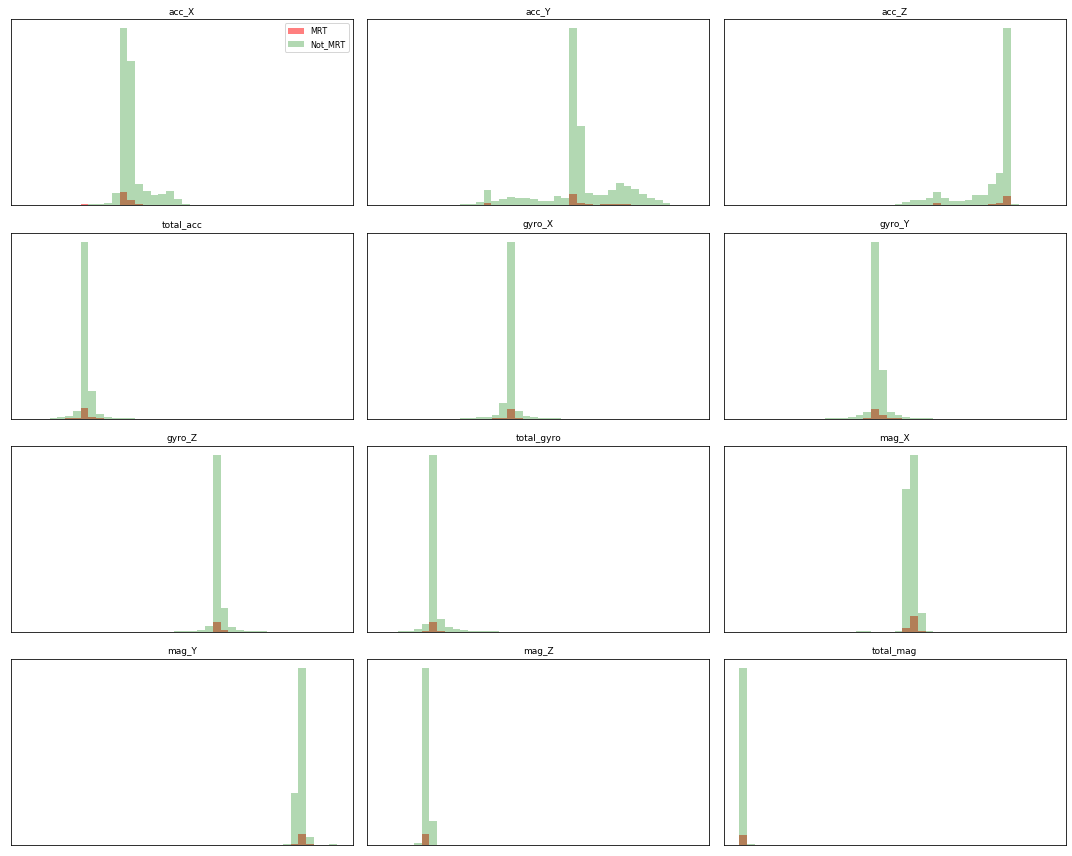

In [0]:
fig, axes = plt.subplots(4, 3, figsize = (15, 12)) 
MRT = df1.loc[df1.Mode == 'MRT']
Not_MRT = df1.loc[df1.Mode == 'Not_MRT']
ax = axes.ravel()

for i in range(12):
  _, bins = np.histogram(df1.iloc[:, i + 1], bins = 40)
  ax[i].hist(MRT.iloc[:, i + 1], bins = bins, color = 'r', alpha = 0.5)
  ax[i].hist(Not_MRT.iloc[:, i + 1], bins = bins, color = 'g', alpha = 0.3)
  ax[i].set_title(feature_names[i], fontsize = 9)
  ax[i].axes.get_xaxis().set_visible(False) 
  ax[i].set_yticks(())
  
ax[0].legend(['MRT', 'Not_MRT'], loc = 'best', fontsize = 8)
plt.tight_layout()
plt.show()

**Apply PCA on the scaled dataset.**

Instead of choosing the number of components manually, we will be using the option that allows us to **set the variance** of the input that is supposed to be **explained by the generated components**.

Typically, we want the explained variance to be between **95–99%**. We will use **95%** here.

As usual to prevent **data leakage**, we fit PCA on the **training data set**, and then we transform the **test data set** using the already **fitted pca**.

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components = 0.95) 
pca.fit(X_train_scaled) 
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

Let's check the shape of both PCA arrays. **48** features are required to explain **95%** of the variance.

In [0]:
print("Shape of X_train_scaled_pca: ", X_train_scaled_pca.shape)
print("Shape of X_test_scaled_pca: ", X_test_scaled_pca.shape)

Shape of X_train_scaled_pca:  (47215, 48)
Shape of X_test_scaled_pca:  (20230, 48)


Now, the data has only **48** features. Drawback of PCA is it’s not easy to tell how the initial features combined to form the principal components. 

How would other number of components affect the results? We can check by measuring the variance ratio of the principal components. It's not very easy to tell **how each component contributes to the variance** from these numbers. It will be easier to visualize using a suitable plot.

In [0]:
ex_variance = np.var(X_train_scaled_pca, axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio) 

[0.25758883 0.14893418 0.06916607 0.05921112 0.04551018 0.0396331
 0.03570478 0.03140147 0.02521865 0.02119544 0.02077526 0.01871667
 0.01578351 0.01553555 0.01339158 0.01057406 0.00976064 0.00948902
 0.00925015 0.00869873 0.00720557 0.00706636 0.00663793 0.00644232
 0.00600887 0.00570796 0.00545391 0.00528924 0.00521339 0.00515092
 0.00504684 0.00494176 0.00487261 0.00482624 0.0048026  0.00466414
 0.00456596 0.00438736 0.00424231 0.00422726 0.00408194 0.00384647
 0.00380612 0.00368219 0.00346007 0.00302102 0.0029571  0.00285254]


**Plotting the Cumulative Summation of the Explained Variance**
- As seen, **48 components explain 95% of the variance**.
- It is also interesting and possibly useful to note that **17 of the components can explain 80% of the variance**. This might help to reduce the model training time later if 48 components take too long to train.

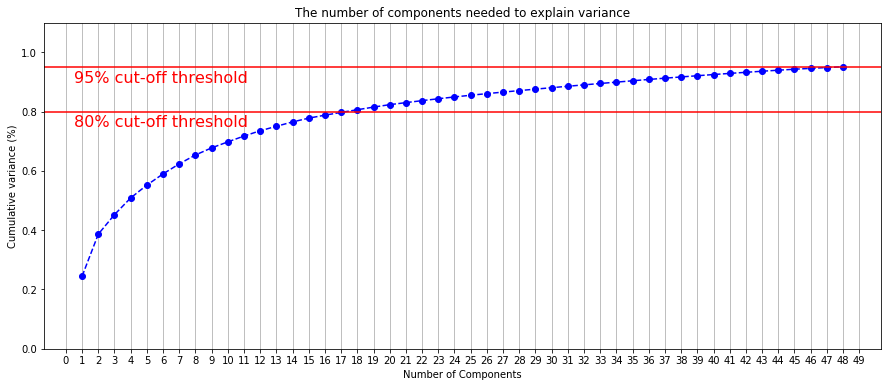

In [0]:
plt.rcParams["figure.figsize"] = (15, 6)

fig, ax = plt.subplots()
xi = np.arange(1, 49, step = 1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker = 'o', linestyle = '--', color = 'b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 50, step = 1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y = 0.95, color = 'r', linestyle = '-')
plt.text(0.5, 0.90, '95% cut-off threshold', color = 'red', fontsize = 16)
plt.axhline(y = 0.80, color = 'r', linestyle = '-')
plt.text(0.5, 0.75, '80% cut-off threshold', color = 'red', fontsize = 16)

ax.grid(axis = 'x')
plt.show()

To get how the **principal components** are **linearly related** with the different features, we can create a dataframe with the pca components.

Each coefficient represents the **correlation between a particular pair of component and feature**. All values are bounded within **[0, 1] range**.

For example, we can see that gyro_Y and	PC-23 are moderately inversely related since the correlation coefficient is -0.419230. 

In [0]:
pd.DataFrame(pca.components_, columns = feature_names, 
             index = ['PC{}'.format(i + 1) for i in range(48)])

acc_X     acc_Y  ...  Entropy mag_Z  Entropy total_mag
PC1   0.072543 -0.038163  ...       0.102114           0.096770
PC2   0.003395 -0.007397  ...       0.023518           0.032380
PC3   0.086526 -0.151161  ...      -0.078119          -0.067274
PC4  -0.088866  0.067239  ...      -0.043555          -0.040598
PC5   0.037734  0.000999  ...       0.006110           0.009583
PC6   0.151849  0.183543  ...       0.046513           0.029318
PC7  -0.052709 -0.101106  ...       0.051382           0.063192
PC8   0.003966  0.036113  ...       0.005482           0.017017
PC9   0.002011 -0.040151  ...      -0.083891          -0.058718
PC10  0.051100 -0.036228  ...       0.000136           0.006581
PC11 -0.022067 -0.017284  ...       0.004623           0.015045
PC12 -0.111013  0.018544  ...       0.062295           0.046059
PC13  0.088424  0.009423  ...      -0.058904          -0.061494
PC14 -0.088259  0.016252  ...       0.030127          -0.011325
PC15  0.047297 -0.037066  ...      -0.007273           0.005096
PC16 -0.003656  0.059746  ...      -0.111907          -0.119209
PC17 -0.035298  0.042484  ...      -0.055617          -0.056385
PC18  0.039760 -0.006996  ...      -0.015999          -0.003216
PC19 -0.043770  0.059621  ...      -0.098965          -0.113437
PC20 -0.037608  0.024783  ...      -0.059230          -0.092418
PC21  0.018435  0.019896  ...      -0.050714          -0.070194
PC22  0.027010 -0.004391  ...      -0.044477          -0.053282
PC23  0.031925 -0.003337  ...      -0.009413          -0.013446
PC24 -0.011963 -0.000698  ...      -0.017021          -0.024107
PC25 -0.051330  0.076320  ...      -0.091103          -0.108907
PC26  0.041384 -0.023613  ...      -0.022362          -0.039412
PC27 -0.032257 -0.030284  ...       0.016900           0.018320
PC28  0.045925 -0.002067  ...       0.025097           0.038432
PC29 -0.024656 -0.001016  ...      -0.004655           0.012529
PC30  0.060536 -0.061687  ...      -0.013614          -0.029997
PC31 -0.022652 -0.003724  ...       0.001405          -0.011203
PC32 -0.002149  0.016056  ...      -0.006301          -0.017422
PC33  0.018842  0.002133  ...       0.005585           0.012326
PC34  0.004333  0.004889  ...      -0.003253           0.001473
PC35 -0.021492 -0.003822  ...       0.004447           0.004814
PC36  0.028355 -0.015118  ...      -0.012963          -0.011763
PC37 -0.012256  0.058189  ...      -0.008792          -0.009202
PC38  0.032351 -0.037574  ...       0.008830           0.017325
PC39  0.013750  0.008966  ...       0.035700           0.054651
PC40 -0.042392  0.047923  ...       0.023645           0.014025
PC41  0.029576 -0.014870  ...       0.054637           0.063570
PC42 -0.054621  0.038863  ...      -0.008561           0.035532
PC43  0.109850 -0.044780  ...      -0.006663          -0.020136
PC44 -0.042982  0.029363  ...      -0.009046          -0.053815
PC45  0.004335  0.020307  ...      -0.022268           0.002165
PC46 -0.040225  0.019908  ...       0.091928           0.146285
PC47  0.022134 -0.038365  ...      -0.187060          -0.298812
PC48  0.018953  0.009514  ...       0.039986           0.065550

[48 rows x 216 columns]

**Get the most important feature of each principal component.**

In [0]:
n_pcs = 48
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i + 1): most_important_names[i] for i in range(n_pcs)}
importance = pd.DataFrame(sorted(dic.items()))
importance.rename(columns = {0: 'PC', 1: 'Most Important Feature'}, inplace = True)
importance['temp_holder'] = importance['PC'].str.split('(\d+)').str[1].astype(int)
importance = importance.sort_values('temp_holder', ascending = True).drop('temp_holder', axis=1)
importance.set_index('PC', inplace = True)
del importance.index.name

**Mean, variance, skewness, kurtosis** extracted features appeared relatively lots of time.

From the original 9 sensor data, only **gyro_X** and **gyro_Z** appeared once each as the most important feature for PC40 and PC48 respectively. 


In [0]:
importance

Most Important Feature
PC1          STD total_gyro
PC2           p90 total_mag
PC3               Max acc_Y
PC4             Mean gyro_Z
PC5               p90 mag_X
PC6              Mean acc_Y
PC7             Mean gyro_X
PC8             Mean gyro_X
PC9      Variance total_acc
PC10              p90 mag_Y
PC11             p75 gyro_Z
PC12            Mean gyro_Y
PC13         Variance mag_Z
PC14         Variance mag_Z
PC15         Kurtosis acc_Z
PC16         Variance acc_X
PC17        Variance gyro_X
PC18         Variance acc_Y
PC19        Variance gyro_Z
PC20    Skewness total_gyro
PC21        Variance gyro_Y
PC22     Skewness total_acc
PC23        Skewness gyro_X
PC24     Kurtosis total_mag
PC25              IQR acc_X
PC26        Skewness gyro_Y
PC27         Kurtosis mag_X
PC28         Skewness acc_X
PC29        Skewness gyro_Z
PC30         Skewness acc_Y
PC31    Kurtosis total_gyro
PC32         Skewness mag_Y
PC33        Kurtosis gyro_Z
PC34        Kurtosis gyro_X
PC35        Kurtosis gyro_Z
PC36         Skewness mag_X
PC37         Skewness acc_Y
PC38     Skewness total_mag
PC39    Kurtosis total_gyro
PC40                 gyro_X
PC41        Kurtosis gyro_Y
PC42              IQR mag_Y
PC43              total_acc
PC44         Kurtosis mag_X
PC45         Kurtosis acc_X
PC46         Kurtosis acc_Y
PC47         Kurtosis acc_X
PC48                 gyro_Z

Find out which **sensor** (no matter what statistical feature extracted) **appeared the most number of times as the most important feature in the principal components**.

As seen, **gyroscope tops the ranking**, followed by accelerometer then magnetometer. **Gyroscope standard deviation** is also the most important feature in principal component 1 which is the direction representing the most variation out of all principal components.

In [0]:
acc_count = 0
gyro_count = 0
mag_count = 0

for row in importance['Most Important Feature']:
  if "acc" in row:
    acc_count += 1
  elif "gyro" in row:
    gyro_count += 1
  else:
    mag_count += 1

print("Number of times each sensor type appeared as the most important feature of a principal component")
print('-' * 98)
print("Accelerometer: ", acc_count)
print("Gyroscope: ", gyro_count)
print("Magnetometer: ", mag_count)

Number of times each sensor type appeared as the most important feature of a principal component
--------------------------------------------------------------------------------------------------
Accelerometer:  15
Gyroscope:  21
Magnetometer:  12


In [0]:
mean_count = 0
var_count = 0
skew_count = 0
kurt_count = 0
others = 0

for row in importance['Most Important Feature']:
  if "Mean" in row:
    mean_count += 1
  elif "Variance" in row:
    var_count += 1
  elif "Skewness" in row:
    skew_count += 1
  elif "Kurtosis" in row:
    kurt_count += 1
  else:
    others += 1
print("Number of times each statistical type appeared as the most important feature of a principal component")
print('-' * 98)
print("Mean: ", mean_count)
print("Variance: ", var_count)
print("Skewness: ", skew_count)
print("Kurtosis: ", kurt_count)
print("Others: ", others)

Number of times each statistical type appeared as the most important feature of a principal component
--------------------------------------------------------------------------------------------------
Mean:  5
Variance:  8
Skewness:  11
Kurtosis:  13
Others:  11


Load PCA results from numpy array to pandas dataframe

In [0]:
X_train_scaled_pca = pd.DataFrame(X_train_scaled_pca, columns = ['PC{}'.format(i + 1) for i in range(48)])
X_test_scaled_pca = pd.DataFrame(X_test_scaled_pca, columns = ['PC{}'.format(i + 1) for i in range(48)])

In [0]:
X_train_scaled_pca

PC1        PC2       PC3  ...      PC46      PC47      PC48
0       8.035316  -0.597784 -6.674810  ...  0.373102 -0.028374  0.868403
1       8.505549  -0.740034 -4.603865  ... -1.005622 -0.018476 -1.370116
2      10.443352  -0.898659 -2.533335  ... -1.402508  0.619682 -1.093704
3      12.076319  -0.780227 -1.492889  ... -1.422778  0.712479 -0.297882
4      11.963175  -0.718418 -1.408019  ... -0.126460  0.701093  0.268142
...          ...        ...       ...  ...       ...       ...       ...
47210  -3.264383  41.852563 -0.205112  ...  2.006104 -0.942438  0.966654
47211  -3.106386  41.834299 -0.487881  ...  1.745585 -0.731999  0.908226
47212  -3.201749  41.330661 -0.535033  ...  1.989644 -0.816694  0.539040
47213  -3.796474  40.551545  0.230582  ...  0.988290 -1.706832  0.573404
47214  -3.947282  39.761741  0.391204  ...  0.667352 -1.570783  0.775671

[47215 rows x 48 columns]

In [0]:
X_test_scaled_pca

PC1        PC2       PC3  ...      PC46      PC47      PC48
0       9.218152  -0.271228 -6.627512  ... -0.727853  0.138616 -0.191866
1      14.264671   0.336130 -5.670705  ... -1.539710  1.181769  0.229662
2      15.941249   0.439027 -6.472572  ...  0.760500  1.036665 -0.615430
3      16.813941   0.891745 -7.448326  ...  0.996447  1.487188  0.737749
4      17.524862   1.141364 -8.707287  ...  1.455824  1.082001  0.527030
...          ...        ...       ...  ...       ...       ...       ...
20225   2.354084  45.948874 -9.809830  ...  2.149137 -2.354846  1.954089
20226   1.389023  46.841968 -7.579401  ...  2.525219 -4.696631  2.405606
20227  -2.723046  42.275010 -0.701206  ...  1.065681 -1.488086  1.204644
20228  -2.697054  42.031876 -0.758651  ...  1.414553 -1.324692  1.422806
20229  -2.865938  41.716788 -0.683374  ...  2.203971 -0.616733  1.406523

[20230 rows x 48 columns]

**Check for NAs. 0 found.**

In [0]:
X_train_scaled_pca.isna().sum().sum()

0

In [0]:
X_test_scaled_pca.isna().sum().sum()

0

Ensure **datatypes** are correct. Both have only **float64** datatype.

In [0]:
print(X_train_scaled_pca.dtypes.unique())
print(X_test_scaled_pca.dtypes.unique())

[dtype('float64')]
[dtype('float64')]


**Classifier Training/Evaluation**

- We will test out the same models as before PCA from sklearn before trying out other models. Once we are able to get a feel of which models have potential to perform well, we will pick those models and start to tune the hyperparameters. Like before, only the training set will be used for crossvalidation to lower training time as we are training in bulk.

In [0]:
models1 = []

models1.append(("LogisticRegression", LogisticRegression()))
models1.append(("SVC", SVC()))
models1.append(("LinearSVC", LinearSVC()))
models1.append(("KNeighbors", KNeighborsClassifier()))
models1.append(("DecisionTree", DecisionTreeClassifier()))
models1.append(("RandomForest", RandomForestClassifier(verbose = 3, n_jobs = -1)))
models1.append(("GaussianNB", GaussianNB()))
models1.append(("MLPClassifier", MLPClassifier(solver = 'lbfgs', random_state = 0)))

results1 = []
names1 = []

In [0]:
for name, model in models1:
    result1 = cross_val_score(model, X_train_scaled_pca, Y_train,  cv = 5, scoring = 'f1_weighted')
    names1.append(name)
    results1.append(result1)

**F1 Score Comparison**------------Before PCA (216) | After PCA (48)----------------
- **LogisticRegression** --------------------0.91710 | 0.92014
- **SVC** -----------------------------*(Rank 2)* 0.94076 | 0.93772 *(Rank 3)*
- **LinearSVC** ---------------------------------0.91584 | 0.91704
- **KNeighbors** -------------------------------0.92328 | 0.92413
- **DecisionTree** -----------------------------0.92687 | 0.93004
- **RandomForest** -------------*(Rank 1)* 0.94866  | 0.95004 *(Rank 1)*
- **GaussianNB** ------------------------------0.33205 | 0.52965
- **MLPClassifier** --------------*(Rank 3)* 0.93195  | 0.93880 *(Rank 2)*

 



The top 3 models are still the same after PCA except the rank 2 and 3 swop positions between SVC (rbf kernel) and MLPClassifier. **All the models (except SVC) improved their F1 Score after PCA** with less features and reduced training time.

In [0]:
print('F1 Score\n--------------------------------------')
for i in range(len(names1)):
    print(names1[i], round(results1[i].mean(), 5))

**Comparison of Standard Deviation of Cross Validation based on F1 Score (%)**

----------------------------------------**Before PCA (204) | After PCA (48)**----------------------------------------
- **LogisticRegression**----------*(Rank 1)* 0.48  | 0.72 *(Rank 2)*
- **SVC**---------------------------------------------1.64 | 1.43 *(Rank 3)*
- **LinearSVC**-----------------------*(Rank 2)* 0.89  | 0.25 *(Rank 1)*
- **KNeighbors**---------------------*(Rank 3)* 1.62  | 1.58
- **DecisionTree**--------------------------------2.91 | 3.22
- **RandomForest**------------------------------3.25 | 3.20
- **GaussianNB**--------------------------------14.72 | 20.92
- **MLPClassifier**------------------*(Rank 3)* 1.62  | 2.56



In [0]:
print('Standard Deviation of Cross Validation (%)\n-------------------------------------------')
for i in range(len(names1)):
    print(names1[i], round(results1[i].std() * 100, 2))

**Boosting Algorithms**
- The term 'Boosting' refers to a family of algorithms which converts weak learner to strong learners. Boosting is an ensemble method for improving the model predictions of any given learning algorithm. The idea of boosting is to train weak learners sequentially, each trying to correct its predecessor.
- We will be trying out **AdaBoost, CatBoost, Light GBM, XGBoost**.

In [0]:
stk = StratifiedKFold(n_splits = 5)

**AdaBoost (Adaptive Boosting)**
- Adaboost combines multiple “weak classifiers” into a single “strong classifier”.
- AdaBoost works by putting more weight on difficult to classify instances and less on those already handled well.

In [0]:
from sklearn.ensemble import AdaBoostClassifier

In [0]:
adaboost = AdaBoostClassifier(n_estimators = 100, random_state = 0)
adaboost_F1 = cross_val_score(adaboost, X_train_scaled_pca, Y_train,  cv = stk, scoring = 'f1_macro')

Average F1 Macro = 0.7128196698577027

In [0]:
adaboost_F1.mean()

0.7128196698577027

**CatBoost**
- Hyper-parameter tuning is seldom needed when using CatBoost.
- CatBoost which is implemented by powerful theories like ordered Boosting, Random permutations, makes sure that we are not overfitting our model. It also implements symmetric trees which eliminates parameters like (min_child_leafs). We can further tune with parameters like learning_rate, random_strength, L2_regulariser, but the results usually doesn’t vary much.

In [0]:
!pip install catboost

     |████████████████████████████████| 63.9MB 48kB/s 


In [0]:
from catboost import CatBoostClassifier

In [0]:
catboost = CatBoostClassifier(random_state = 0)
catboost_F1 = cross_val_score(catboost, X_train_scaled_pca, Y_train,  cv = stk, scoring = 'f1_macro')

Average F1 Macro = 0.7222007359671294

In [0]:
catboost_F1.mean()

In [0]:
catboost.fit(X_train_scaled_pca, Y_train)

In [0]:
y_pred = catboost.predict(X_test_scaled_pca)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

In [0]:
acc = accuracy_score(Y_test, y_pred)
fscore = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('------------------------------------\nCatBoost\n------------------------------------')
print('Classification performance metrics\n------------------------------------')
print('Accuracy: {:.4f}'.format(acc))
print('F1 Score: {:.4f}'.format(fscore))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

**Light GBM**

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

Run a default setting lightgbm first.

**F1 macro-average** will be used in place of accuracy or F1-weighted based on different considerations for **precision-recall tradeoff**.

A F1 macro-average will **compute the metric independently for each class** and then take the average (hence **treating all classes equally**). This is ideal for **imbalanced datasets**.

In [0]:
from lightgbm import LGBMClassifier

In [0]:
lgbm = LGBMClassifier(objective = 'binary', random_state = 0)
lgbm_F1 = cross_val_score(lgbm, X_train_scaled_pca, Y_train,  cv = stk, scoring = 'f1_macro')

Average F1 Macro Score = 0.7212124651470277

In [0]:
lgbm_F1.mean()

As Light GBM only takes around **10-15 seconds** to run and the default parameters already look quite promising, it is worth **tuning the hyperparameters** to aim for better results. We will attempt **random search** first, which is more flexible and more efficient than a grid search. We will also utilize the trainset and testset now.

If the close-to-optimal region of hyperparameters occupies at least 5% of the grid surface, then random search with **60 trials** will find that region with high probability **(95%)**. Higher number can be used if running time is low enough to avoid unlucky searches.

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [0]:
fit_params = {"eval_metric": 'auc', 
              "eval_names": ['valid'],
              "verbose": 100}

In [0]:
param_test = {'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc = 0.2, scale = 0.8), 
              'colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
              'n_estimators': [50, 100, 150]}
              
#This parameter defines the number of hyperparameter points to be tested.
n_HP_points_to_test = 100

#is_unbalance = True gave better results compared to tuning various scaleposweight
lgbm_tuned = LGBMClassifier(objective = 'binary', random_state = 0, is_unbalance = True) 

gs = RandomizedSearchCV(
    estimator = lgbm_tuned, param_distributions = param_test, 
    n_iter = n_HP_points_to_test,
    scoring = 'f1_macro',
    cv = stk,
    refit = True,
    verbose = True)

Best Average F1 Macro reached: 0.7271336837697994

Params: {'colsample_bytree': 0.5989147519171187, 'min_child_samples': 152, 'min_child_weight': 0.01, 'n_estimators': 150, 'num_leaves': 49, 'reg_alpha': 2, 'reg_lambda': 0, 'subsample': 0.8711234237005314} 

In [0]:
gs.fit(X_train_scaled_pca, Y_train)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

**View the optimal parameters for the best estimator.**

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5989147519171187,
 'importance_type': 'split',
 'is_unbalance': True,

 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 152,
 'min_child_weight': 0.01,
 'min_split_gain': 0.0,

 'n_estimators': 150,
 'n_jobs': -1,
 'num_leaves': 49,
 'objective': 'binary',
 'random_state': 0,
 
 'reg_alpha': 2,
 'reg_lambda': 0,
 'silent': True,
 'subsample': 0.8711234237005314,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [0]:
gs.best_estimator_.get_params()

Build and test the final model using the optimal hyperparameters. 

In [0]:
import lightgbm as lgb

boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5989147519171187, importance_type='split',
               is_unbalance=True, learning_rate=0.1, max_depth=-1,
               min_child_samples=152, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=49, objective='binary',
               random_state=0, reg_alpha=2, reg_lambda=0, silent=True,
               subsample=0.8711234237005314, subsample_for_bin=200000,
               subsample_freq=0

We can adjust the number of estimators or leaves depending on whether we want higher precision or recall. 

In [0]:
lgbm_final = LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5989147519171187, importance_type='split',
               is_unbalance=True, learning_rate=0.1, max_depth=-1,
               min_child_samples=152, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=49, objective='binary',
               random_state=0, reg_alpha=2, reg_lambda=0, silent=True,
               subsample=0.8711234237005314, subsample_for_bin=200000,
               subsample_freq=0)
lgbm_final_F1 = cross_val_score(lgbm_final, X_train_scaled_pca, Y_train,  cv = stk, scoring = 'f1_macro')

In [0]:
lgbm_final_F1.mean()

In [0]:
lgbm_final.fit(X_train_scaled_pca, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5989147519171187, importance_type='split',
               is_unbalance=True, learning_rate=0.1, max_depth=-1,
               min_child_samples=152, min_child_weight=0.01, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=49, objective='binary',
               random_state=0, reg_alpha=2, reg_lambda=0, silent=True,
               subsample=0.8711234237005314, subsample_for_bin=200000,
               subsample_freq=0)

In [0]:
y_pred = lgbm_final.predict(X_test_scaled_pca)

**Confusion Matrix**
- **True Positives (TP):** Predicted Not MRT correctly
- **True Negatives (TN):** Predicted MRT correctly
- **False Positives (FP):** Predicted Not MRT but actual is MRT
- **False Negatives (FN):** Predicted MRT but actual is Not MRT

In [0]:
print(confusion_matrix(Y_test, y_pred))

[[  752   377]
 [  115 18986]]


**0 = MRT**

**1 = Not_MRT**

In [0]:
pd.crosstab(Y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted'], margins = True)

Predicted    0      1    All
Actual                      
0          752    377   1129
1          115  18986  19101
All        867  19363  20230

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

True Positives (TP):  18986
True Negatives (TN):  752
False Positives (FP):  377
False Negatives (FN):  115


**Key performance metrics**

The model optimizes recall instead of precision. In this case, recall can be thought as of a model’s ability to find all the data points of interest (MRT) in a dataset. A **precision-recall tradeoff** is common in many scenarios and it often boils down to the business problem that the company wants to solve or improve on.

In [0]:
from sklearn.metrics import classification_report

In [0]:
print(classification_report(Y_test, y_pred, target_names = ['MRT', 'Not_MRT']))

              precision    recall  f1-score   support

         MRT       0.90      0.68      0.77      1129
     Not_MRT       0.98      1.00      0.99     19101

    accuracy                           0.98     20230
   macro avg       0.94      0.84      0.88     20230
weighted avg       0.98      0.98      0.98     20230



In [0]:
acc = accuracy_score(Y_test, y_pred)
fscore = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('------------------------------------\nFinal LightGBM with random search\n------------------------------------')
print('Classification performance metrics\n------------------------------------')
print('Accuracy: {:.4f}'.format(acc))
print('F1 Score: {:.4f}'.format(fscore))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

------------------------------------
Final LightGBM with random search
------------------------------------
Classification performance metrics
------------------------------------
Accuracy: 0.9778
F1 Score: 0.9883
Precision: 0.9812
Recall: 0.9956


**ADASYN: Adaptive Synthetic Sampling Method for Imbalanced Data**
- ADASYN works similarly to the regular SMOTE. However, the number of samples generated for each x_i is proportional to the number of samples which are not from the same class than x_i in a given neighborhood. Therefore, more samples will be generated in the area that the nearest neighbor rule is not respected.

In [0]:
from imblearn.over_sampling import ADASYN

Examine the class imbalance severity

In [0]:
print('MRT: {}'.format(np.bincount(Y_train)[0]))
print('Not MRT: {}'.format(np.bincount(Y_train)[1]))

MRT: 2633
Not MRT: 44582


Create a copy of x and y training set so we can preserve the original data.

In [0]:
X_train_scaled_pca_adasyn = X_train_scaled_pca.copy()
Y_train_adasyn = Y_train.copy()

In [0]:
X_train_scaled_pca_adasyn.shape

(47215, 48)

In [0]:
Y_train_adasyn.shape

(47215,)

In [0]:
ada = ADASYN(sampling_strategy = 'minority', random_state = 0)

In [0]:
X_train_scaled_pca_adasyn, Y_train_adasyn = ada.fit_resample(X_train_scaled_pca_adasyn, Y_train_adasyn)

Check the new oversampled data

In [0]:
print('MRT: {}'.format(np.bincount(Y_train_adasyn)[0]))
print('Not MRT: {}'.format(np.bincount(Y_train_adasyn)[1]))

MRT: 44467
Not MRT: 44582


In [0]:
X_train_scaled_pca_adasyn.shape

(89049, 48)

In [0]:
X_train_scaled_pca_adasyn = pd.DataFrame(X_train_scaled_pca_adasyn, columns = ['PC{}'.format(i + 1) for i in range(48)])

In [0]:
X_train_scaled_pca_adasyn

PC1       PC2       PC3  ...      PC46      PC47      PC48
0       8.035316 -0.597784 -6.674810  ...  0.373102 -0.028374  0.868403
1       8.505549 -0.740034 -4.603865  ... -1.005622 -0.018476 -1.370116
2      10.443352 -0.898659 -2.533335  ... -1.402508  0.619682 -1.093704
3      12.076319 -0.780227 -1.492889  ... -1.422778  0.712479 -0.297882
4      11.963175 -0.718418 -1.408019  ... -0.126460  0.701093  0.268142
...          ...       ...       ...  ...       ...       ...       ...
89044  12.181548 -1.134693 -8.819130  ... -0.009613 -0.407059  0.709878
89045  13.394153 -1.056211 -7.887602  ...  0.535683 -0.133810 -0.665246
89046  13.546862 -1.299817 -7.446131  ... -0.135946 -0.856686 -0.061037
89047  13.549468 -1.184812 -7.594461  ...  0.221496 -0.467587 -0.368661
89048  12.635882 -1.020350 -8.544457  ...  0.236929 -0.498533 -0.533756

[89049 rows x 48 columns]

Try out the Light GBM again after ADASYN.


In [0]:
lgbm_adasyn = LGBMClassifier(objective = 'binary', random_state = 0)
lgbm_adasyn_F1 = cross_val_score(lgbm_adasyn, X_train_scaled_pca_adasyn, Y_train_adasyn,  cv = stk, scoring = 'f1_macro')

Average F1 Macro Score = 0.7726197432644524

In [0]:
lgbm_adasyn_F1.mean()

Perform a random grid search for optimal hyperparameters.

In [0]:
fit_params_adasyn = {"eval_metric": 'auc', 
                "eval_names": ['valid'],
                "verbose": 100}

In [0]:
param_test_adasyn = {'num_leaves': sp_randint(6, 50), 
                    'min_child_samples': sp_randint(100, 500), 
                    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                    'subsample': sp_uniform(loc = 0.2, scale = 0.8), 
                    'colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
                    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
                    'n_estimators': [50, 100, 150]}
                
#This parameter defines the number of hyperparameter points to be tested.
n_HP_points_to_test_adasyn = 100

lgbm_tuned_adasyn = LGBMClassifier(objective = 'binary', random_state = 0) 

gs_adasyn = RandomizedSearchCV(
      estimator = lgbm_tuned_adasyn, param_distributions = param_test_adasyn, 
      n_iter = n_HP_points_to_test_adasyn,
      scoring = 'f1_macro',
      cv = stk,
      refit = True,
      verbose = True)

Best Average F1 Macro reached = 0.8363076914894679



In [0]:
gs_adasyn.fit(X_train_scaled_pca_adasyn, Y_train_adasyn)
print('Best score reached: {} with params: {} '.format(gs_adasyn.best_score_, gs_adasyn.best_params_))

**View optimal hyperparameters**

boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6418492283669386, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=224,
               min_child_weight=0.1, min_split_gain=0.0, n_estimators=450,
               n_jobs=-1, num_leaves=43, objective='binary', random_state=0,
               reg_alpha=0, reg_lambda=20, silent=True,
               subsample=0.6859749901481736, subsample_for_bin=200000,
               subsample_freq=0

In [0]:
gs_adasyn.best_estimator_.get_params()

Input the optimal hyperparameters into a new model.

In [0]:
lgbm_final_adasyn = LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                  colsample_bytree=0.6418492283669386, importance_type='split',
                                  learning_rate=0.1, max_depth=-1, min_child_samples=224,
                                  min_child_weight=0.1, min_split_gain=0.0, n_estimators=450,
                                  n_jobs=-1, num_leaves=43, objective='binary', random_state=0,
                                  reg_alpha=0, reg_lambda=20, silent=True,
                                  subsample=0.6859749901481736, subsample_for_bin=200000,
                                  subsample_freq=0)

In [0]:
lgbm_final_adasyn.fit(X_train_scaled_pca_adasyn, Y_train_adasyn)

In [0]:
y_pred = lgbm_final_adasyn.predict(X_test_scaled_pca)

Confusion matrix components
- Lower FP but FN increased substantially.

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

Key classification performance metrics

In [0]:
acc = accuracy_score(Y_test, y_pred)
fscore = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('------------------------------------\nFinal LightGBM with ADASYN and \nrandom search\n------------------------------------')
print('Classification performance metrics\n------------------------------------')
print('Accuracy: {:.4f}'.format(acc))
print('F1 Score: {:.4f}'.format(fscore))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

**Borderline-SMOTE: Over-Sampling Method in Imbalanced Data Sets**
- Only the minority examples near the borderline are over-sampled unliked the normal SMOTE and ADASYN.

In [0]:
from imblearn.over_sampling import BorderlineSMOTE

In [0]:
X_train_scaled_pca_smote = X_train_scaled_pca.copy()
Y_train_smote = Y_train.copy()

In [0]:
X_train_scaled_pca_smote

PC1        PC2       PC3  ...      PC46      PC47      PC48
0       8.035316  -0.597784 -6.674810  ...  0.373102 -0.028374  0.868403
1       8.505549  -0.740034 -4.603865  ... -1.005622 -0.018476 -1.370116
2      10.443352  -0.898659 -2.533335  ... -1.402508  0.619682 -1.093704
3      12.076319  -0.780227 -1.492889  ... -1.422778  0.712479 -0.297882
4      11.963175  -0.718418 -1.408019  ... -0.126460  0.701093  0.268142
...          ...        ...       ...  ...       ...       ...       ...
47210  -3.264383  41.852563 -0.205112  ...  2.006104 -0.942438  0.966654
47211  -3.106386  41.834299 -0.487881  ...  1.745585 -0.731999  0.908226
47212  -3.201749  41.330661 -0.535033  ...  1.989644 -0.816694  0.539040
47213  -3.796474  40.551545  0.230582  ...  0.988290 -1.706832  0.573404
47214  -3.947282  39.761741  0.391204  ...  0.667352 -1.570783  0.775671

[47215 rows x 48 columns]

In [0]:
Y_train_smote.shape

(47215,)

In [0]:
smote = BorderlineSMOTE(random_state = 0)

In [0]:
X_train_scaled_pca_smote, Y_train_smote = smote.fit_resample(X_train_scaled_pca_smote, Y_train_smote)

In [0]:
print('MRT: {}'.format(np.bincount(Y_train_smote)[0]))
print('Not MRT: {}'.format(np.bincount(Y_train_smote)[1]))

MRT: 44582
Not MRT: 44582


In [0]:
X_train_scaled_pca_smote = pd.DataFrame(X_train_scaled_pca_smote, columns = ['PC{}'.format(i + 1) for i in range(48)])

In [0]:
X_train_scaled_pca_smote

PC1       PC2       PC3  ...      PC46      PC47      PC48
0       8.035316 -0.597784 -6.674810  ...  0.373102 -0.028374  0.868403
1       8.505549 -0.740034 -4.603865  ... -1.005622 -0.018476 -1.370116
2      10.443352 -0.898659 -2.533335  ... -1.402508  0.619682 -1.093704
3      12.076319 -0.780227 -1.492889  ... -1.422778  0.712479 -0.297882
4      11.963175 -0.718418 -1.408019  ... -0.126460  0.701093  0.268142
...          ...       ...       ...  ...       ...       ...       ...
89159   1.505673  0.071614 -3.366717  ... -1.097254 -0.128696 -0.249382
89160   0.001364 -1.713815 -3.503721  ... -0.274531 -0.145289 -0.083528
89161  25.497659  1.574106  9.664675  ...  0.188998  0.100284  1.874097
89162   2.735611 -0.320008  5.450924  ... -1.473161 -0.765325 -0.575001
89163   7.148966 -0.108156 -6.071539  ...  0.310815  1.152768 -0.248616

[89164 rows x 48 columns]

**Original vs Upsample (SMOTE) Scatterplot**

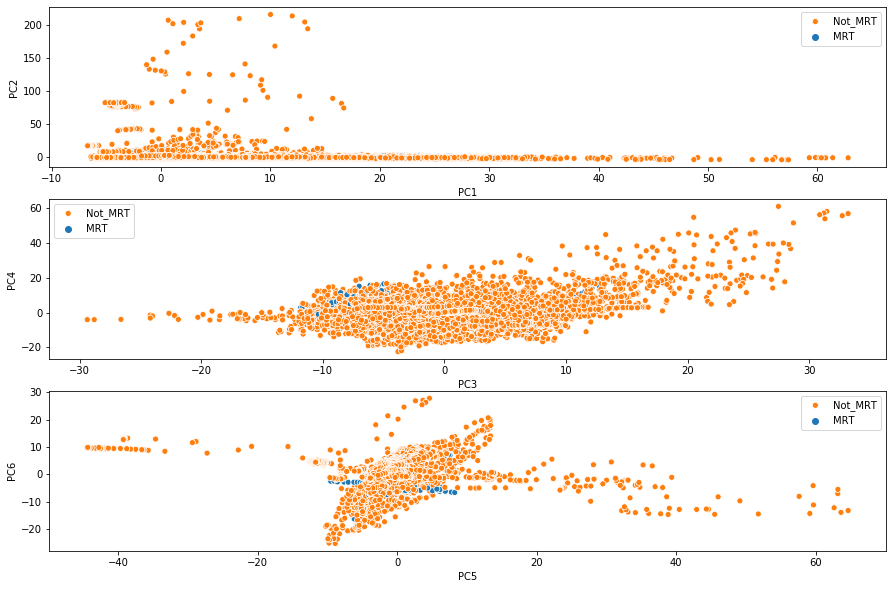

In [0]:
fig, axs = plt.subplots(nrows=3)
fig.set_size_inches(15,10)
sns.scatterplot(X_train_scaled_pca['PC1'], X_train_scaled_pca['PC2'], hue = Y_train, ax = axs[0])
sns.scatterplot(X_train_scaled_pca['PC3'], X_train_scaled_pca['PC4'], hue = Y_train, ax = axs[1])
sns.scatterplot(X_train_scaled_pca['PC5'], X_train_scaled_pca['PC6'], hue = Y_train, ax = axs[2])
for i in range(3):
  axs[i].legend(labels=['Not_MRT', 'MRT']);

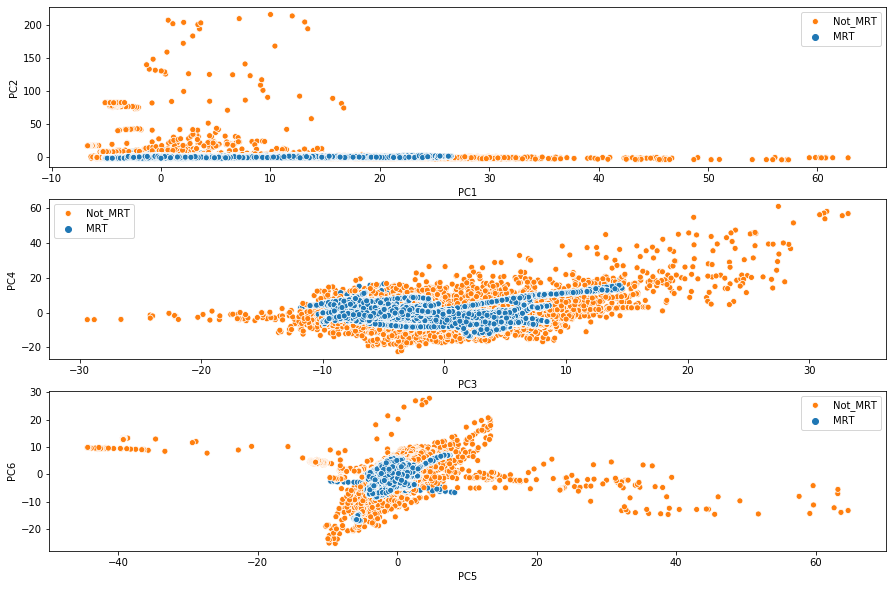

In [0]:
fig, axs = plt.subplots(nrows=3)
fig.set_size_inches(15,10)
sns.scatterplot(X_train_scaled_pca_smote['PC1'], X_train_scaled_pca_smote['PC2'], hue = Y_train_smote, ax = axs[0])
sns.scatterplot(X_train_scaled_pca_smote['PC3'], X_train_scaled_pca_smote['PC4'], hue = Y_train_smote, ax = axs[1])
sns.scatterplot(X_train_scaled_pca_smote['PC5'], X_train_scaled_pca_smote['PC6'], hue = Y_train_smote, ax = axs[2])
for i in range(3):
  axs[i].legend(labels=['Not_MRT', 'MRT']);

Try out the Light GBM again after borderline SMOTE.

In [0]:
lgbm_smote = LGBMClassifier(objective = 'binary', random_state = 0)
lgbm_smote_F1 = cross_val_score(lgbm_smote, X_train_scaled_pca_smote, Y_train_smote,  cv = stk, scoring = 'f1_macro')

Average F1 Macro Score = 0.9652964639795574

In [0]:
lgbm_smote_F1.mean()

Perform a random grid search for optimal hyperparameters.

In [0]:
fit_params_smote = {"eval_metric": 'auc', 
                  "eval_names": ['valid'],
                  "verbose": 100}

We will try out more n _estimators this time as it appears to overfit less than we initially expected.

In [0]:
param_test_smote = {'num_leaves': sp_randint(6, 50), 
                    'min_child_samples': sp_randint(100, 500), 
                    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
                    'subsample': sp_uniform(loc = 0.2, scale = 0.8), 
                    'colsample_bytree': sp_uniform(loc = 0.4, scale = 0.6),
                    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
                    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
                    'n_estimators': [100, 150, 200, 300, 400]}
                
#This parameter defines the number of hyperparameter points to be tested.
n_HP_points_to_test_smote = 100

lgbm_tuned_smote = LGBMClassifier(objective = 'binary', random_state = 0) 

gs_smote = RandomizedSearchCV(
      estimator = lgbm_tuned_smote, param_distributions = param_test_smote, 
      n_iter = n_HP_points_to_test_smote,
      scoring = 'f1_macro',
      cv = stk,
      refit = True,
      verbose = True)

Best Average F1 Macro reached = 0.9768054298085241

In [0]:
gs_smote.fit(X_train_scaled_pca_smote, Y_train_smote)
print('Best score reached: {} with params: {} '.format(gs_smote.best_score_, gs_smote.best_params_))

View optimal hyperparameters

In [0]:
gs_smote.best_estimator_.get_params()

Input the optimal hyperparameters into a new model.

boosting_type='gbdt', class_weight=None,
                                colsample_bytree=0.4426409673347405, importance_type='split',
                                learning_rate=0.1, max_depth=-1, min_child_samples=138,
                                min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
                                n_jobs=-1, num_leaves=42, objective='binary', random_state=0,
                                reg_alpha=0.1, reg_lambda=0, silent=True,
                                subsample=0.500825614323837, subsample_for_bin=200000,
                                subsample_freq=0

In [0]:
lgbm_final_smote = LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=0.4426409673347405, importance_type='split',
                                learning_rate=0.15, max_depth=-1, min_child_samples=138,
                                min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
                                n_jobs=-1, num_leaves=42, objective='binary', random_state=0,
                                reg_alpha=0.1, reg_lambda=0, silent=True,
                                subsample=0.500825614323837, subsample_for_bin=200000,
                                subsample_freq=0)

In [0]:
lgbm_final_smote.fit(X_train_scaled_pca_smote, Y_train_smote)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.4426409673347405, importance_type='split',
               learning_rate=0.15, max_depth=-1, min_child_samples=138,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=42, objective='binary', random_state=0,
               reg_alpha=0.1, reg_lambda=0, silent=True,
               subsample=0.500825614323837, subsample_for_bin=200000,
               subsample_freq=0)

In [0]:
y_pred = lgbm_final_smote.predict(X_test_scaled_pca)

Confusion matrix components
- FP increased a bit but FN less by approximately halved compared to ADASYN.

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

True Positives (TP):  18986
True Negatives (TN):  752
False Positives (FP):  377
False Negatives (FN):  115


Key classification performance metrics

In [0]:
acc = accuracy_score(Y_test, y_pred)
fscore = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('------------------------------------\nFinal LightGBM with SMOTE borderline\nusing random search\n------------------------------------')
print('Classification performance metrics\n------------------------------------')
print('Accuracy: {:.4f}'.format(acc))
print('F1 Score: {:.4f}'.format(fscore))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

------------------------------------
Final LightGBM with SMOTE borderline
using random search
------------------------------------
Classification performance metrics
------------------------------------
Accuracy: 0.9757
F1 Score: 0.9872
Precision: 0.9805
Recall: 0.9940


**LGBM using hyperopt with smote dataset**
- fmin - main function to minimize
- tpe and anneal - optimization approaches
- hp - include different distributions of variables
- Trials - used for logging

**TPE (Tree-structured Parzen Estimator)** is a default algorithm for the Hyperopt. It uses **Bayesian approach for optimization**. At every step it is trying to **build probabilistic model** of the function and **choose the most promising parameters** for the next step.

In [0]:
import hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt.plotting import main_plot_history

In [0]:
random_state = 0
def lgb_cv(params, random_state = random_state, cv = stk, X = X_train_scaled_pca_smote, y = Y_train_smote):
    params = {'class_weight': params['class_weight'],
              'num_leaves': int(params['num_leaves']),
              'learning_rate': params['learning_rate'],
              'subsample_for_bin': int(params['subsample_for_bin']),
              'min_child_samples': int(params['min_child_samples']),
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'colsample_bytree': params['colsample_bytree'],
              'n_estimators': int(params['n_estimators'])}
    
    lgbm_hyperopt = LGBMClassifier(random_state = random_state, **params)
    score = cross_val_score(lgbm_hyperopt, X, y, cv = cv, scoring = "f1_macro", n_jobs = -1).mean()
    
    #Since we are trying to maximize the cross-validation f1_macro, we must negate this value for hyperopt, since hyperopt only knows how to minimize a function.
    return -score

In [0]:
space = {'class_weight': hp.choice('class_weight', [None, 'balanced']),
         'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
         'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
         'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
         'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
         'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
         'n_estimators': hp.quniform('n_estimators', 100, 1000, 10)}   

# trials will contain logging information
trials = Trials()

best=fmin(fn = lgb_cv, # function to optimize
          space = space, 
          algo = tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals = 100, # maximum number of iterations
          trials = trials, # logging
          rstate = np.random.RandomState(random_state) # fixing random state for the reproducibility
        )

**Best parameters using bayes optimization**

{'class_weight': 1,
 'colsample_bytree': 0.9825572986491371,
 'learning_rate': 0.039582238123710964,
 'min_child_samples': 55.0,
 'n_estimators': 630.0,
 'num_leaves': 134.0,
 'reg_alpha': 0.37019063225526716,
 'reg_lambda': 0.1260962426950094,
 'subsample_for_bin': 60000.0}

In [0]:
best

In [0]:
lgbm_hyperopt_final = LGBMClassifier(class_weight = None,
                                  colsample_bytree = 0.9825572986491371,
                                  learning_rate = 0.039582238123710964,
                                  min_child_samples = 55,
                                  n_estimators = 630,
                                  num_leaves = 134,
                                  reg_alpha = 0.37019063225526716,
                                  reg_lambda = 0.1260962426950094,
                                  subsample_for_bin = 60000, 
                                  objective = 'binary', 
                                  random_state = 0)

In [0]:
lgbm_hyperopt_final.fit(X_train_scaled_pca_smote, Y_train_smote)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9825572986491371, importance_type='split',
               learning_rate=0.039582238123710964, max_depth=-1,
               min_child_samples=55, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=630, n_jobs=-1, num_leaves=134, objective='binary',
               random_state=0, reg_alpha=0.37019063225526716,
               reg_lambda=0.1260962426950094, silent=True, subsample=1.0,
               subsample_for_bin=60000, subsample_freq=0)

In [0]:
y_pred = lgbm_hyperopt_final.predict(X_test_scaled_pca)

Results are slightly better than using random search. False positives are higher by an insignificant amount.

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

True Positives (TP):  19037
True Negatives (TN):  739
False Positives (FP):  390
False Negatives (FN):  64


In [0]:
acc = accuracy_score(Y_test, y_pred)
fscore = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('------------------------------------\nFinal LightGBM with SMOTE borderline\nand bayes optimisation (hyperopt)\n------------------------------------')
print('Classification performance metrics\n------------------------------------')
print('Accuracy: {:.4f}'.format(acc))
print('F1 Score: {:.4f}'.format(fscore))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

------------------------------------
Final LightGBM with SMOTE borderline
and bayes optimisation (hyperopt)
------------------------------------
Classification performance metrics
------------------------------------
Accuracy: 0.8859
F1 Score: 0.9361
Precision: 0.9926
Recall: 0.8857


**Ensemble learning using heterogeneous algorithms**
- Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.
- We will be testing out the ensemble using different base algorithms.


**Ensemble 1**
- Final LightGBM with SMOTE borderline
and bayes optimisation (hyperopt)
- Random Forest

In [0]:
clf1 = lgbm_hyperopt_final
clf2 = RandomForestClassifier(random_state = 0)

print('5-fold cross validation:\n')

labels = ['lgbm_hyperopt_final', 'Random Forest']

for clf, label in zip([clf1, clf2], labels):
    scores = cross_val_score(clf, X_train_scaled_pca_smote, Y_train_smote, cv = stk, scoring = 'f1_macro')          
    print("F1 Macro: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

In [0]:
from sklearn.ensemble import VotingClassifier

**Ensemble vote methods**
- In **hard voting** (also known as majority voting), every individual classifier votes for a class, and the **majority wins**. In statistical terms, the predicted target label of the ensemble is the mode of the distribution of individually predicted labels.
- In **soft voting**, every individual classifier provides a **probability value** that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.

In [0]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], clf1),
                                                 (labels[1], clf2)],
                                                  voting = 'hard')

In [0]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], clf1),
                                                 (labels[1], clf2)],
                                                  voting = 'soft')

**Comparison of results**
- F1 Macro: 0.9816 (+/- 0.0227) [lgbm_hyperopt_final]
- F1 Macro: 0.9788 (+/- 0.0375) [Random Forest]
- F1 Macro: 0.9812 (+/- 0.0225) [Voting_Classifier_Hard]
- **F1 Macro: 0.9824 (+/- 0.0249) [Voting_Classifier_Soft]** ***

**The ensemble which used a soft voting system performed the best.**

In [0]:
labels_new = ['lgbm_hyperopt_final', 'Random Forest',
              'Voting_Classifier_Hard', 'Voting_Classifier_Soft']

for (clf, label) in zip([clf1, clf2,voting_clf_hard,
                        voting_clf_soft], labels_new):
    scores = cross_val_score(clf, X_train_scaled_pca_smote, Y_train_smote, cv = stk, scoring = 'f1_macro')
            
    print("F1 Macro: %0.4f (+/- %0.4f) [%s]"
          % (scores.mean(), scores.std(), label))

In [0]:
voting_clf_soft.fit(X_train_scaled_pca_smote, Y_train_smote)

In [0]:
y_pred = voting_clf_soft.predict(X_test_scaled_pca)

False positive is quite high although overall result is good.

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

In [0]:
acc = accuracy_score(Y_test, y_pred)
fscore = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('------------------------------------\nEnsemble 1\n------------------------------------')
print('Classification performance metrics\n------------------------------------')
print('Accuracy: {:.4f}'.format(acc))
print('F1 Score: {:.4f}'.format(fscore))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

**Ensemble 2 (Attempt to combine low correlation models to get higher precision score)**
- Final LightGBM with SMOTE borderline
and bayes optimisation (hyperopt)
- Random Forest
- K-Nearest Neighbour


In [0]:
clf1 = lgbm_hyperopt_final
clf2 = RandomForestClassifier(random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 10, n_jobs = -1, weights = 'distance')
# print('5-fold cross validation:\n')

labels = ['lgbm_hyperopt_final', 'Random Forest', 'K-Nearest Neighbour']

# for clf, label in zip([clf1, clf2, clf3, clf4], labels):
#     scores = cross_val_score(clf, X_train_scaled_pca_smote, Y_train_smote, cv = stk, scoring = 'f1_macro')          
#     print("F1 Macro: %0.4f (+/- %0.4f) [%s]"
#           % (scores.mean(), scores.std(), label))

Only hard voting since k_nearest neighbour does not output any probabilities.

In [0]:
ensemble2 = VotingClassifier(estimators = [(labels[0], clf1),
                                           (labels[1], clf2),
                                           (labels[2], clf3)],
                                            voting = 'hard')

In [0]:
ensemble2.fit(X_train_scaled_pca_smote, Y_train_smote)

In [0]:
y_pred = ensemble2.predict(X_test_scaled_pca)

Adding KNeighborsClassifier to the ensemble reduced false positives only by a little bit while false negatives close to doubled.

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

In [0]:
acc = accuracy_score(Y_test, y_pred)
fscore = f1_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print('------------------------------------\nEnsemble 2\n------------------------------------')
print('Classification performance metrics\n------------------------------------')
print('Accuracy: {:.4f}'.format(acc))
print('F1 Score: {:.4f}'.format(fscore))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

**Creating a Stacking ensemble**

The main idea behind the structure of a stacked generalization is to use one or more first level models, make predictions using these models and then use these predictions as features to fit one or more second level models on top. To avoid overfitting, cross-validation is usually used to predict the OOF (out-of-fold) part of the training set. 

Train a normal xgboost first.

In [0]:
from xgboost import XGBClassifier

In [0]:
xgboost = XGBClassifier(random_state=0) 

In [0]:
xgboost.fit(X_train_scaled_pca_smote, Y_train_smote)

In [0]:
y_pred = xgboost.predict(X_test_scaled_pca)

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

Import vecstack

In [0]:
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19879 sha256=5ddda8ff61bbaf5054210df7ccd33a0220afa63aa150d8ba778316c6365fde25
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [0]:
from vecstack import stacking

Define first level models. We will use light gbm, random forest and K-Nearest Neighbour.

In [0]:
base_models = [lgbm_hyperopt_final,
               RandomForestClassifier(random_state=0, n_jobs=-1),
               KNeighborsClassifier(n_neighbors = 10, n_jobs = -1, weights = 'distance')]

Use first level models to make predictions.

In [0]:
S_train, S_test = stacking(base_models,                   
                           X_train_scaled_pca_smote, Y_train_smote, X_test_scaled_pca,   
                           regression=False, 
                           mode='oof_pred', 
                           needs_proba=False,
                           save_dir=None, 
                           metric=f1_score, 
                           n_folds=4, 
                           stratified=True,
                           shuffle=True,  
                           random_state=0,    
                           verbose=2)

Fit the second level model on new S_train and same Y_train_smote.

In [0]:
second_level_model = lgbm_hyperopt_final
second_level_model = second_level_model.fit(S_train, Y_train_smote)

In [0]:
y_pred = second_level_model.predict(S_test)

In [0]:
print('Final F1 score: [%.4f]' % f1_score(Y_test, y_pred))

Results are around the same as just the lgbm model alone. Probably due to the other models not being highly complementary. 

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

In [0]:
cm = confusion_matrix(Y_test, y_pred)
labels = ['MRT', 'Not_MRT']
plt.figure(figsize = (10, 6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt = 'd', cmap = "Blues", vmin = 0.2)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted');

In [0]:
random_state = 0
def lgb_cv(params, random_state = random_state, cv = stk, X = X_train_scaled_pca_smote, y = Y_train_smote):
    params = {
              'lambda_l1': params['lambda_l1'],
              'lambda_l2': params['lambda_l2'],
              'bagging_fraction': params['bagging_fraction'],
              'feature_fraction': params['feature_fraction'],
              'min_child_weight': int(params['min_child_weight']),
              'max_depth': int(params['max_depth']),
              'num_leaves': int(params['num_leaves']),
              'learning_rate': params['learning_rate'],
              'subsample_for_bin': int(params['subsample_for_bin']),
              'min_child_samples': int(params['min_child_samples']),
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'colsample_bytree': params['colsample_bytree'],
              'n_estimators': int(params['n_estimators'])
              }
    
    lgbm_hyperopt = LGBMClassifier(random_state = random_state, **params)
    score = cross_val_score(lgbm_hyperopt, X, y, cv = cv, scoring = 'balanced_accuracy', n_jobs = -1).mean()
    
    #Since we are trying to maximize the cross-validation balanced accuracy, we must negate this value for hyperopt, since hyperopt only knows how to minimize a function.
    return -score

In [0]:
space = {
         'lambda_l1': hp.uniform('lambda_l1', 0, 10),
         'lambda_l2': hp.uniform('lambda_l2', 0, 10),
         'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
         'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
         'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),    
         'max_depth': hp.choice('max_depth', np.arange(5, 500, 1, dtype=int)),
         'num_leaves': hp.quniform('num_leaves', 30, 500, 1),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
         'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
         'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
         'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
         'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
         'n_estimators': hp.quniform('n_estimators', 100, 2000, 10)
         }   

# trials will contain logging information
trials = Trials()

best=fmin(fn = lgb_cv, # function to optimize
          space = space, 
          algo = tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals = 10, # maximum number of iterations
          trials = trials, # logging
          rstate = np.random.RandomState(random_state) # fixing random state for the reproducibility
        )

In [0]:
best

In [0]:
lgbm_base = LGBMClassifier(bagging_fraction=0.8239380890961142,
                            colsample_bytree=0.6564372010201727,
                            feature_fraction=0.8228837452300735,
                            lambda_l1=1.1060812598163006,
                            lambda_l2=3.8426260049170367,
                            learning_rate=0.026037541366905403,
                            max_depth=421,
                            min_child_samples=120,
                            min_child_weight=6,
                            n_estimators=1650,
                            num_leaves=244,
                            reg_alpha=0.46994404036291704,
                            reg_lambda=0.7832662706729936,
                            subsample_for_bin=60000)

In [0]:
lgbm_base.fit(X_train_scaled_pca_smote, Y_train_smote)

In [0]:
y_pred = lgbm_base.predict(X_test_scaled_pca)

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

**Downsample Majority Class To Match Minority Class**

In [0]:
X_train_scaled_pca_downsample = X_train_scaled_pca.copy()

Index of each class' observations

In [0]:
minority_class = np.where(Y_train == 0)[0]
majority_class = np.where(Y_train == 1)[0]

Number of observations in each class

In [0]:
num_minority = len(minority_class)
num_majority = len(majority_class)
print(num_minority)
print(num_majority)

2633
44582


For every observation of class 0, randomly sample from class 1 without replacement.

In [0]:
majority_downsample_index = np.random.choice(majority_class, size = num_minority, replace = False)

In [0]:
Y_train_downsampled = np.hstack((Y_train[minority_class], Y_train[majority_downsample_index]))

In [0]:
X_train_scaled_pca_downsample = pd.concat([X_train_scaled_pca_downsample.iloc[minority_class], X_train_scaled_pca_downsample.iloc[majority_downsample_index]])

In [0]:
X_train_scaled_pca_downsample.shape

(5266, 48)

In [0]:
Y_train_downsampled.shape

(5266,)

**Original vs Downsample Scatterplot**

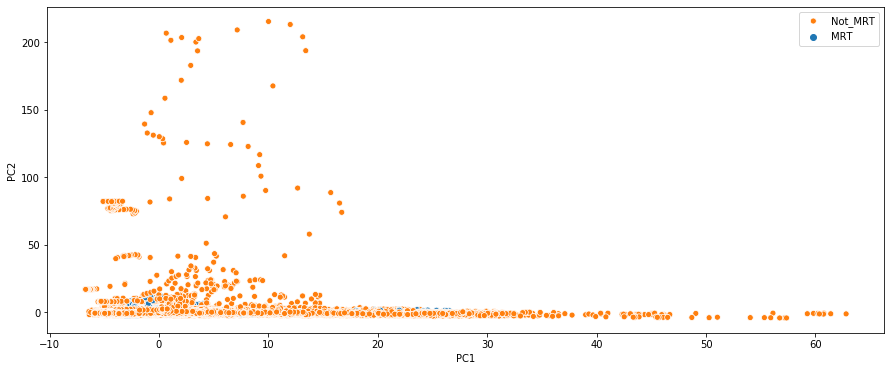

In [0]:
sns.scatterplot(X_train_scaled_pca['PC1'], X_train_scaled_pca['PC2'], hue = Y_train);
plt.legend(['Not_MRT', 'MRT']);

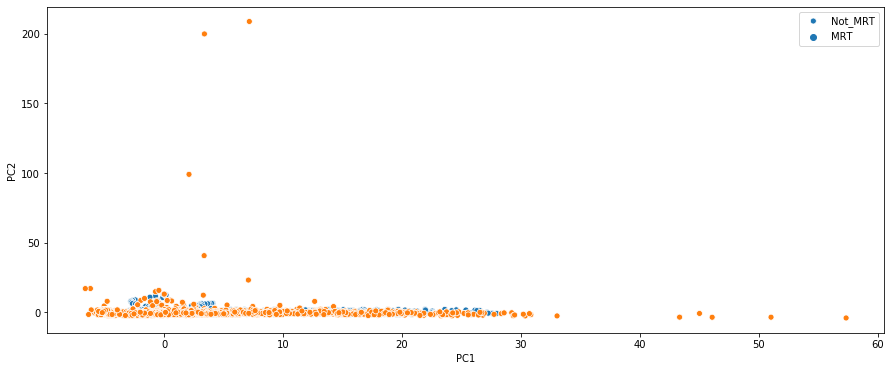

In [0]:
sns.scatterplot(X_train_scaled_pca_downsample['PC1'], X_train_scaled_pca_downsample['PC2'], hue = Y_train_downsampled);
plt.legend(['Not_MRT', 'MRT']);

In [0]:
lgbm_down = LGBMClassifier(random_state=0, objective='binary')

In [0]:
lgbm_down.fit(X_train_scaled_pca_downsample, Y_train_downsampled)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_pred = lgbm_down.predict(X_test_scaled_pca)

False positives decreased at the expense of a much higher false negatives.

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

True Positives (TP):  16918
True Negatives (TN):  1003
False Positives (FP):  126
False Negatives (FN):  2183


In [0]:
random_state = 0
def lgb_cv(params, random_state = random_state, cv = stk, X = X_train_scaled_pca_downsample, y = Y_train_downsampled):
    params = {
              'min_split_gain': params['min_split_gain'],
              'lambda_l1': params['lambda_l1'],
              'lambda_l2': params['lambda_l2'],
              'bagging_fraction': params['bagging_fraction'],
              'feature_fraction': params['feature_fraction'],
              'min_child_weight': int(params['min_child_weight']),
              'max_depth': int(params['max_depth']),
              'num_leaves': int(params['num_leaves']),
              'learning_rate': params['learning_rate'],
              'subsample_for_bin': int(params['subsample_for_bin']),
              'min_child_samples': int(params['min_child_samples']),
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'colsample_bytree': params['colsample_bytree'],
              'n_estimators': int(params['n_estimators'])
              }
    
    lgbm_hyperopt = LGBMClassifier(random_state = random_state, **params)
    score = cross_val_score(lgbm_hyperopt, X, y, cv = cv, scoring = 'accuracy', n_jobs = -1).mean()
    
    #Since we are trying to maximize the cross-validation accuracy, we must negate this value for hyperopt, since hyperopt only knows how to minimize a function.
    return -score

In [0]:
space = {
         'min_split_gain': hp.uniform('min_split_gain', 0, 1),
         'lambda_l1': hp.uniform('lambda_l1', 0, 10),
         'lambda_l2': hp.uniform('lambda_l2', 0, 10),
         'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
         'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
         'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),    
         'max_depth': hp.choice('max_depth', np.arange(5, 500, 1, dtype=int)),
         'num_leaves': hp.quniform('num_leaves', 30, 500, 1),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
         'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
         'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
         'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
         'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
         'n_estimators': hp.quniform('n_estimators', 100, 1000, 10)
         }   

# trials will contain logging information
trials = Trials()

best=fmin(fn = lgb_cv, # function to optimize
          space = space, 
          algo = tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
          max_evals = 100, # maximum number of iterations
          trials = trials, # logging
          rstate = np.random.RandomState(random_state) # fixing random state for the reproducibility
        )

In [0]:
best

In [0]:
lgbm_down_final = LGBMClassifier(bagging_fraction=0.8921323925356002,
                                colsample_bytree=0.7980766017338348,
                                feature_fraction=0.9910885456406309,
                                lambda_l1=6.984581837677049,
                                lambda_l2=6.326299545238446,
                                learning_rate=0.17514159505121518,
                                max_depth=51,
                                min_child_samples=50,
                                min_child_weight=5,
                                n_estimators=500,
                                num_leaves=50,
                                reg_alpha=0.7553394428215362,
                                reg_lambda=0.003868594832861727,
                                subsample_for_bin=100000)

In [0]:
lgbm_down_final.fit(X_train_scaled_pca_downsample, Y_train_downsampled)

In [0]:
y_pred = lgbm_down_final.predict(X_test_scaled_pca)

In [0]:
tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
print('True Positives (TP): ', tp)
print('True Negatives (TN): ' , tn)
print('False Positives (FP): ' , fp)
print('False Negatives (FN): ' , fn)

In [0]:
main_plot_history(trials)